# Data & Apprentissage Assignment (Part 1), Aicha MAAOUI

#### Table of contents:

[Exercise 1](#ex1)
<a href='ex1'></a>

[Exercise 2](#ex2)
<a href='ex2'></a>

[Exercise 3](#ex3)
<a href='ex3'></a>

[Exercise 4](#ex4)
<a href='ex4'></a>

[Exercise 5](#ex5)
<a href='ex5'></a>

[Exercise 6](#ex6)
<a href='ex6'></a>

[Exercise 7](#ex7)
<a href='ex7'></a>

[Exercise 8](#ex8)
<a href='ex8'></a>

[Exercise 9](#ex9)
<a href='ex9'></a>

## Exercise 1: <a id='ex1'></a>

## Part 1 (a) :

In this first part of the exercise, a from-scratch version of the **RANSAC** algorithm will be implemented and tested using a case study provided in Lab2 and [4](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py). 

The **RANSAC algorithm** [1](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html) [2](https://fr.wikipedia.org/wiki/RANSAC) (short for **RANdom SAmple Consensus** algorithm) solves the commun issue of separating the noisy data (called *outliers*) from the robust data used for modeling the problem (points called *inliers*), to provide a good estimation (reliable prediction) of the model. It is based on the assumption that the ratio ($\frac{inliers}{outliers}$) is important and enough to predict correct pattern. This could be assured using the so-called the *tolerance threshold*, containing the inliers as shown in figure (1.1). 

<!-- 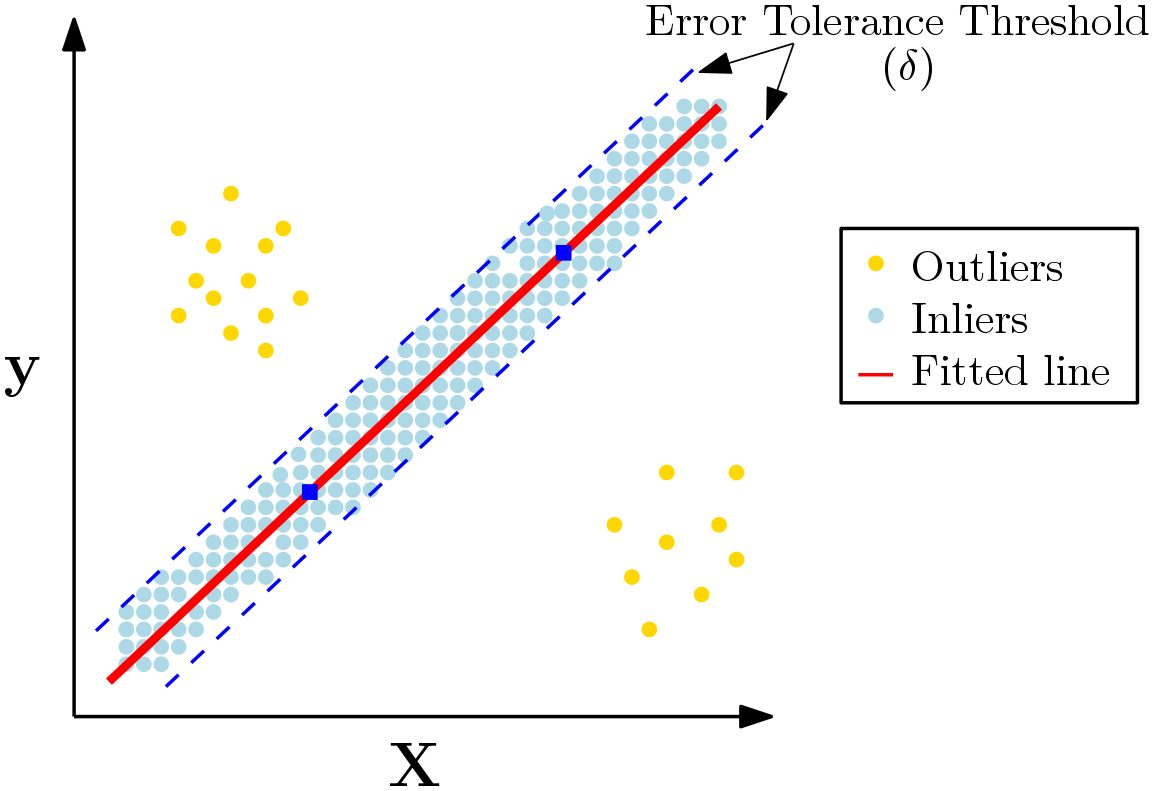 -->
<div>
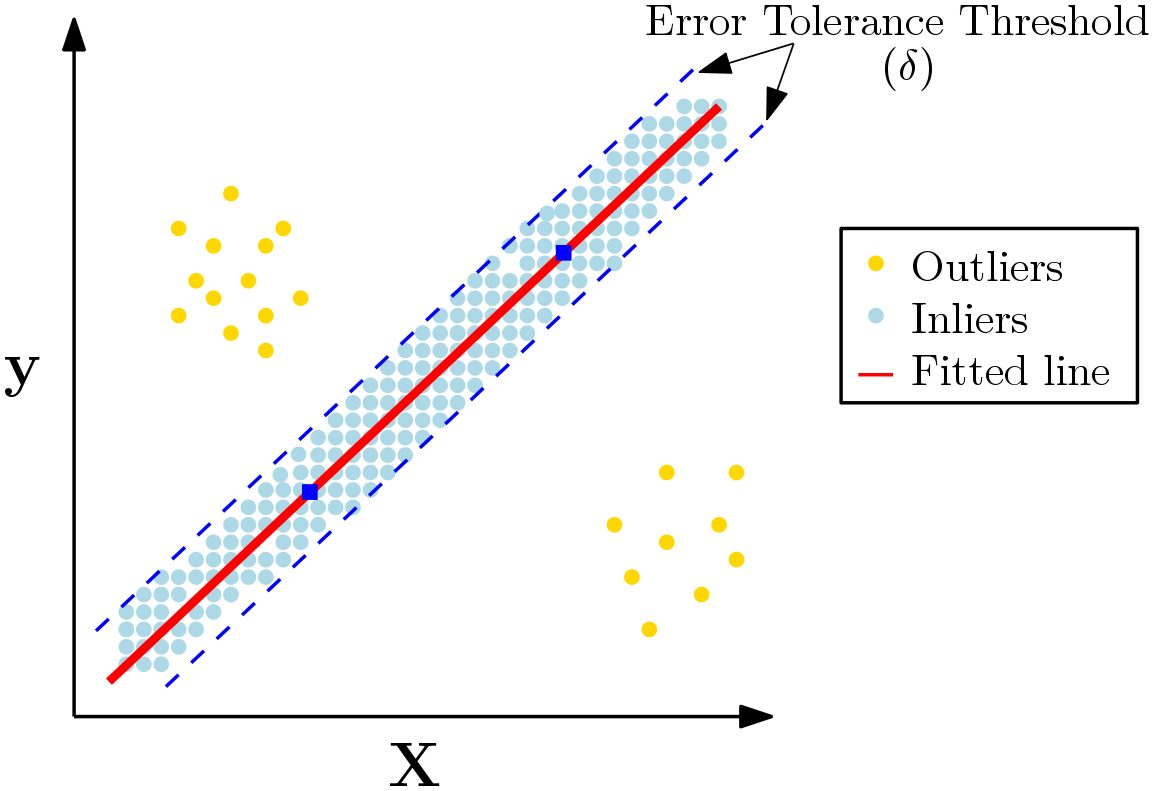
</div>

**Figure 1.1: Illustration of fitting data points using RANSAC.**

### Building my own version of RANSAC (MYRANSAC)

The following algorithm is inspired from the sKlearn documentation [1](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html) and [2](https://fr.wikipedia.org/wiki/RANSAC). The pseudocode describes the working flow of RANSAC:
1. Select -randomly- a subset from the dataset.
2. Create a model candidate trained on this subset.
3. Evaluate the residual of each sample of  dataset when predicted with the candidate model. If the residual is smaller than a threshold, it will be considered as "inlier", otherwise it will be considered as "outlier".
4. Train again a candidate model on the subset of inliers, and evaluate its score also on this subset.
5. Keep track of the candidate model which has the best score, and its corresponding inliers.
6. Go back to Step (1). Stop the model if one of these stopping criteria is met:
    - Number of iteration exceeded maximum allowed number of iterations,
    - Minimum number of inliers is reached.

**Tuning of the RANSAC algorithm parameters [5](https://www.baeldung.com/cs/ransac):**

* $\underline{\text{Determination of the number of required iterations }k:}$

Considering $p$ the desired probability of getting a good sample (without outliers), $n$ the minimum number of samples to define the model and $w$ the probability that a point is an inlier ($w = \frac{inliers}{total \; points}$), the number of iterations could be determined using the following equation:
$\boxed{k = \frac{log(1-p)}{log(1-w^n)}} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\mathbf{(\text{Eq.} \; (1.1))}$

* $\underline{\text{Determination of the threshold :}}$

The threshold, margin in which a point is considered as an inlier, is calculated using the median absolute deviation of the target values of the dataset [1](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html) [5](https://www.baeldung.com/cs/ransac). 

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn import datasets
from matplotlib import pyplot as plt

In [2]:
#Definition of the RANSAC class
class MyRANSAC():
    """
    My RANSAC implementation.
    The variables names and descriptions are highly inspired from Scikit-Learn Doc as requested [1]
    """
    
    def __init__(self, estimator=None, min_samples=None, residual_threshold=None, max_trials=100, stop_n_inliers=np.inf):
        """
        Parameters
        ----------
        estimator: (object, default=None)
            Base estimator object. If None, it is set to LinearRegression
        k : (integer, Optional)
            Maximum number 
        min_samples : (int (>= 1) or float ([0, 1]), default=None)
            Minimum number of data points required to estimate model parameters.
            Treated as an absolute number of samples if min_samples >=1, treated as a 
            relative number for min_samples < 1.
            If None min_samples = X.shape[1]+1
        residual_threshold : (float, default=None)
            Maximum residual for a data sample to be classified as an inlier.
            If None, it is set the median absolute deviation (MAD) of the target
        max_trials : (int, default=100)
            Maximum number of iterations for random sample selection.
        stop_n_inliers : (int, default=np.inf)
            Stop iteration if at least this number of inliers are found.
        
        Returns
        -------
        None.
        
        """
        
        if estimator == None:
            self.estimator = LinearRegression
        else:
            self.estimator = estimator
        self.min_samples = min_samples
        self.residual_threshold = residual_threshold
        self.max_trials = max_trials
        self.stop_n_inliers = stop_n_inliers
        
        
    def fit(self, X, y):
        """
        Fit estimator using RANSAC algorithm. Inspired from [2]: https://fr.wikipedia.org/wiki/RANSAC
        
        **Differences from the algorithm of wikipedia:**
            - The setting of minimal number of new inliners (d) is not required. As long as the inlier is found, 
            the potential model will be verified
        
        **Included features according to my understanding of sklearn documentaion [1]: **
        (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html)
            - Adding some stopping criteria based on "stop_n_inliers" (read descreption in the constructor)
            
        NB: sample_weight is not supported

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training data.
        y : array-like of shape (n_samples,) or (n_samples, n_targets)
            Target values.

        Returns
        -------
        Fitted MyRANSAC estimator.

        """
        self.n_trials_ = 0
        self.estimator_ = None
        best_score = 0
        self.n_skips_no_inliers_ = 0
        
        N = len(X) # total data samples
        
        self.inlier_mask_ = [False for _ in range(N)]
        
        # set nb_samples
        if self.min_samples == None:
            self.nb_samples = X.shape[1]+1
        elif self.min_samples < 1:
            self.nb_samples = int(self.min_samples*N)
        else:
            assert self.min_samples < N, "min_samples should be < X.shape[0]"
            self.nb_samples = self.min_samples
            
        # set residual_threshold if not defined
        if self.residual_threshold == None:
            self.residual_threshold = self._compute_MAD(y)
        
        maybeInliersX = np.zeros((self.nb_samples,X.shape[1]))
        maybeInliersY = np.array([0 for _ in range(self.nb_samples)])
        
        # start iterations
        while self.n_trials_ < self.max_trials:
            # set inlie as False
            self.inlier_mask_ = [False for _ in range(N)]
            
            # randomly selected values from data
            rand_indices = list(np.random.choice(range(N), size=self.nb_samples))
            for idx, pos in enumerate(rand_indices):
                maybeInliersX[idx] = np.copy(X[pos])
                maybeInliersY[idx] = np.copy(y[pos])
            # model parameters fitted on maybeInliers
            maybeModel = self.estimator().fit(maybeInliersX,maybeInliersY)
            # search for other inliers
            inliers_indices = []
            for i in range(N):
                if self._compute_residual(maybeModel, [X[i]], [y[i]]) < self.residual_threshold:
                    inliers_indices.append(i)
            nb_inlier = len(inliers_indices)
            if nb_inlier > 0:
                InliersX = np.zeros((nb_inlier,X.shape[1]))
                InliersY = np.array([0 for _ in range(nb_inlier)])
                for idx, pos in enumerate(inliers_indices):
                    
                    InliersX[idx] = np.copy(X[pos])
                    InliersY[idx] = np.copy(y[pos])
                maybeModel = self.estimator().fit(InliersX,InliersY)
                current_score = maybeModel.score(InliersX,InliersY)
                if current_score > best_score:
                    best_score = current_score
                    self.estimator_ = maybeModel
                    # Setting the mask
                    self.inlier_mask_ = [False for _ in range(N)]
                    for pos in inliers_indices:
                        self.inlier_mask_[pos] = True
                    # Stop iteration if the required number of inliers are found
                    if nb_inlier >= self.stop_n_inliers:
                        break

            # increment iterator
            self.n_trials_ += 1
        
        return self
    
    def _compute_residual(self,model,X,y):
        """
        Compute the sum of squared error between model prediction and true target

        Parameters
        ----------
        model : Object
            Trained model
        X : {array-like or sparse matrix} of shape (n_samples, n_features)
            Input data.
        y : array, shape = [n_samples] or [n_samples, n_targets]
            True target.

        Returns
        -------
        z : float
            sum of squared error
        """
        y_pred = model.predict(X)
        return np.sum([np.abs(y_pred[i]-y[i]) for i in range(len(y))])
    
    def _compute_median(self,y):
        """
        return the median of y

        Parameters
        ----------
        y : array_like

        """
        return sorted(y)[int(len(y)/2)]

    def _compute_MAD(self, y):
        """
        return Median Absolute Deviation of y [3]: https://en.wikipedia.org/wiki/Median_absolute_deviation

        Parameters
        ----------
        y : array_like

        """
        med = self._compute_median(y)
        return self._compute_median([np.abs(yi-med) for yi in y])
        
    def predict(self, X):
        """
        Predict using the estimated model. Wrapper for estimator_.predict(X).

        Parameters
        ----------
        X : {array-like or sparse matrix} of shape (n_samples, n_features)
            Input data.

        Returns
        -------
        y : array, shape = [n_samples] or [n_samples, n_targets]
            Returns predicted values.

        """
        return self.estimator_.predict(X)
        
    def score(self, X, y):
        """
        Return the score of the prediction. Wrapper for estimator_.score(X, y).

        Parameters
        ----------
        X : (array-like or sparse matrix} of shape (n_samples, n_features)
            Training data.
        y : array-like of shape (n_samples,) or (n_samples, n_targets)
            Target values.

        Returns
        -------
        z : float
            Score of the prediction.

        """
        return self.estimator_.score(X, y)

### $\mathbf{\underline{Case \; Study \; (1):}}$ Comparison of LR, sKlearn-RANSAC and MYRANSAC using the example of LAB2 & [4](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py)

The RANSAC is first tested considering the dataset from lab2 and compared to sKlearn-RANSAC and the LinearRegression.

Text(0, 0.5, 'y')

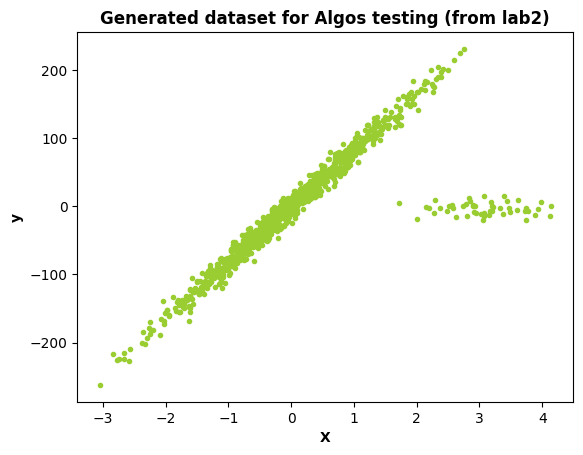

In [3]:
#Defining the Dataset (from LAB2, also an example of sKlearn [4])
#Parameters
nb_samples = 1000
nb_outliers = 50
nb_inliers = 1000 - nb_outliers

#Define the training model (with Gaussian noise=10)
X, y, coef = datasets.make_regression(n_samples=nb_samples, n_features=1, n_informative=1, 
                                      noise=10, coef=True, random_state=0)

# Add outlier data
np.random.seed(0) #seed reset
X[:nb_outliers] = 3 + 0.5 * np.random.normal(size=(nb_outliers, 1))
y[:nb_outliers] = -3 + 10 * np.random.normal(size=nb_outliers)

plt.scatter(X, y, marker='.', color='yellowgreen', label='Inliers')
plt.title("Generated dataset for Algos testing (from lab2)",fontweight="bold")
plt.xlabel("X",fontweight="bold")
plt.ylabel("y",fontweight="bold")
# plt.legend()

Coefficient Comparison 
Coeff:  82.1903908407869
Linear regression coefficient:  [54.17236387]
RANSAC coefficient:  [82.08533159]
MyRANSAC coefficient:  [82.03262673]


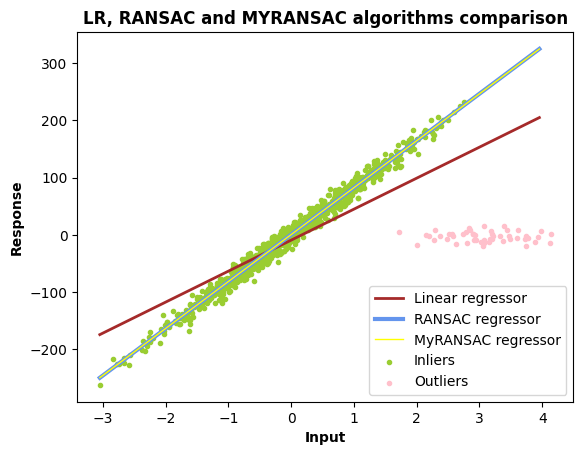

In [4]:
#Training (fit line) of the linear regression model
lr = LinearRegression().fit(X, y)

#Robustly fit linear model with RANSAC algorithm
ransac = RANSACRegressor(residual_threshold=51.0).fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

#MyRANSAC (from-scratch) training
myransac = MyRANSAC().fit(X, y)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)
line_y_myransac = myransac.predict(line_X)

# Compare estimated coefficients
print("========================")
print("Coefficient Comparison ")
print("========================")
print("Coeff: ", coef)
print("Linear regression coefficient: ", lr.coef_)
print("RANSAC coefficient: ", ransac.estimator_.coef_)
print("MyRANSAC coefficient: ", myransac.estimator_.coef_)

#Plotting
LineWidth = 2 #Line width
plt.scatter(
    X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], y[outlier_mask], color="pink", marker=".", label="Outliers"
)
#Plotting of Linear regressor
plt.plot(line_X, line_y, color="brown", linewidth=LineWidth, label="Linear regressor")
#Plotting of RANSAC
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=LineWidth+1,
    label="RANSAC regressor",
)
#Plotting of MyRANSAC
plt.plot(
    line_X,
    line_y_myransac,
    color="yellow",
    linewidth=LineWidth-1,
    label="MyRANSAC regressor",
)
plt.legend(loc="lower right")
plt.title("LR, RANSAC and MYRANSAC algorithms comparison",fontweight="bold")
plt.xlabel("Input",fontweight="bold")
plt.ylabel("Response",fontweight="bold")
plt.show()

From the above results, one conclude the following:
* The **coefficients** predicted by the sKlearn-RANSAC (82.08533159) and MYRANSAC (81.50108139) are close. This highlights the fact that MYRANSAC performs well in the presence of outliers and is comparable to sKlearn-RANSAC,
* The **fitting lines** of sKlearn-RANSAC and MYRANSAC algorithms are superposed.

In what follows, we will be adding different configurations of noisy points and analyzing the RANSAC algorithm's behaviour.

## Part 2 (b) :

### Test 1: Random elements from dataset perturbed "sufficiently" with a Gaussian noise

In this test, we will be using a 1000-point dataset (inline data from inclined linear model). Moreover, extra $p$ ($p=5\%$, $p=10\%$, $p=20\%$ and $p=30\%$) noisy points are added to the dataset. This perturbation is generated randomly using a Gaussian noise. For each generated dataset, the fitted lines obtained by using RANSAC and MYRANSAC are compared, as well as their coefficients.

Coefficient1 Comparison 
Coeff:  83.29434141611843
RANSAC (1) coefficient:  [83.10312963]
MyRANSAC (1) coefficient:  [82.71552232]
Coefficient2 Comparison 
RANSAC (2) coefficient:  [82.94302522]
MyRANSAC (2) coefficient:  [82.83335851]
Coefficient3 Comparison 
RANSAC (3) coefficient:  [83.39641297]
MyRANSAC (3) coefficient:  [83.1070661]
Coefficient4 Comparison 
RANSAC (4) coefficient:  [83.19631537]
MyRANSAC (4) coefficient:  [82.83181356]


<Figure size 640x480 with 0 Axes>

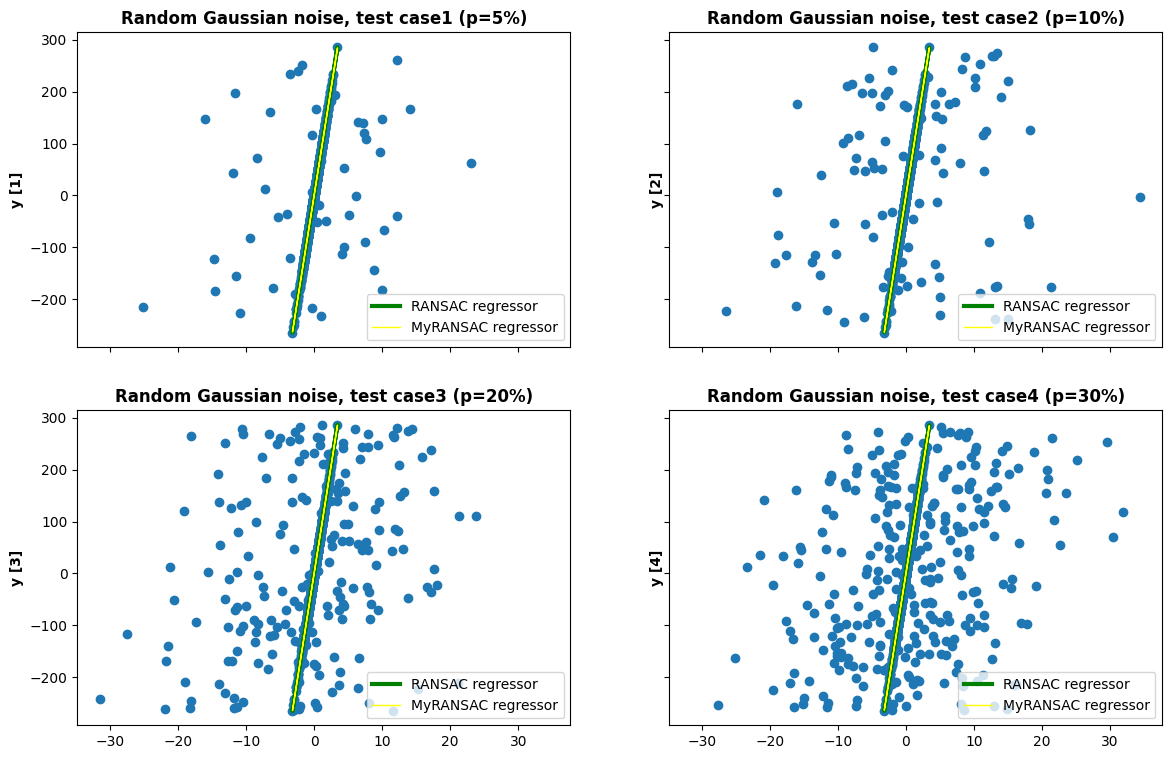

In [5]:
#Test cases parameters
n_samples = 1000
stddev = 10

#Noise percentages
p1 = 0.05 #5%
p2 = 0.1 #10%
p3 = 0.2 #20%
p4 = 0.3 #30%

#Definition of n_noise
n_noise1 = int(p1*n_samples)
n_noise2 = int(p2*n_samples)
n_noise3 = int(p3*n_samples)
n_noise4 = int(p4*n_samples)

#Data definition with random points
X, y, coeff = datasets.make_regression(n_samples=n_samples, n_features=1, n_informative=1, coef=True)
x_min, x_max, y_min, y_max = X.min(), X.max(), y.min(), y.max()
diff_x, diff_y = x_max - x_min, y_max - y_min
denom = np.sqrt(coeff*coeff + 1.0)
x_n, y_n = -coeff/denom, 1.0/denom

#Application  of Gaussian noise
normal_pos1 = np.random.normal(0,stddev,n_noise1)
normal_pos2 = np.random.normal(0,stddev,n_noise2)
normal_pos3 = np.random.normal(0,stddev,n_noise3)
normal_pos4 = np.random.normal(0,stddev,n_noise4)

###################################################################################################
#Case 1: Random elements from dataset perturbed "sufficiently" with a Gaussian noise
###################################################################################################
#Line position
line_pos1 = np.random.uniform(0,1,n_noise1)
line_pos2 = np.random.uniform(0,1,n_noise2)
line_pos3 = np.random.uniform(0,1,n_noise3)
line_pos4 = np.random.uniform(0,1,n_noise4)

#Plotting
fig = plt.figure()    
fig, axs = plt.subplots(nrows = 2, ncols = 2, sharex=True, sharey = True, figsize=(14,9))
#Definition of X and y of noises
#################################################
#p=5%
X_noise1 = [[x_min + line_pos1[i]*diff_x + normal_pos1[i]*x_n] for i in range(n_noise1)]
y_noise1 = [y_min + line_pos1[i]*diff_y + normal_pos1[i]*y_n for i in range(n_noise1)]
#
X1 = np.append(X, X_noise1, axis = 0)
y1 = np.append(y, y_noise1, axis = 0)
#
line_X1 = np.array([x1[0] for x1 in X1])

##RANSAC##
#Robustly fit linear model with RANSAC algorithm
ransac1 = RANSACRegressor().fit(X1, y1)
inlier_mask1 = ransac1.inlier_mask_
outlier_mask1 = np.logical_not(inlier_mask1)

#MyRANSAC (from-scratch) training
myransac1 = MyRANSAC().fit(X1, y1)

# Predict data of estimated models
line_y_ransac1 = ransac1.predict(line_X1.reshape(-1, 1))
line_y_myransac1 = myransac1.predict(line_X1.reshape(-1, 1))

# Compare estimated coefficients
print("========================")
print("Coefficient1 Comparison ")
print("========================")
print("Coeff: ", coeff)
print("RANSAC (1) coefficient: ", ransac1.estimator_.coef_)
print("MyRANSAC (1) coefficient: ", myransac1.estimator_.coef_)

#Plot1
axs[0,0].scatter(line_X1, y1)
axs[0,0].set_title("Random Gaussian noise, test case1 (p=5%)",fontweight="bold")
axs[0,0].set_ylabel("y [1]",fontweight="bold")

#Plotting of RANSAC
axs[0,0].plot(
    line_X1[:n_samples],
    line_y_ransac1[:n_samples],
    color="green",
    linewidth=3,
    label="RANSAC regressor",
)
#Plotting of MyRANSAC
axs[0,0].plot(
    line_X1[:n_samples],
    line_y_myransac1[:n_samples],
    color="yellow",
    linewidth=1,
    label="MyRANSAC regressor",
)
axs[0,0].legend(loc="lower right")

#################################################
#p=10%
X_noise2 = [[x_min + line_pos2[i]*diff_x + normal_pos2[i]*x_n] for i in range(n_noise2)]
y_noise2 = [y_min + line_pos2[i]*diff_y + normal_pos2[i]*y_n for i in range(n_noise2)]
#
X2 = np.append(X, X_noise2, axis = 0)
y2 = np.append(y, y_noise2, axis = 0)
#
line_X2 = np.array([x2[0] for x2 in X2])

##RANSAC##
#Robustly fit linear model with RANSAC algorithm
ransac2 = RANSACRegressor().fit(X2, y2)
inlier_mask2 = ransac2.inlier_mask_
outlier_mask2 = np.logical_not(inlier_mask2)

#MyRANSAC (from-scratch) training
myransac2 = MyRANSAC().fit(X2, y2)

# Predict data of estimated models
line_y_ransac2 = ransac2.predict(line_X2.reshape(-1, 1))
line_y_myransac2 = myransac2.predict(line_X2.reshape(-1, 1))

# Compare estimated coefficients
print("========================")
print("Coefficient2 Comparison ")
print("========================")
print("RANSAC (2) coefficient: ", ransac2.estimator_.coef_)
print("MyRANSAC (2) coefficient: ", myransac2.estimator_.coef_)

#Plot2
axs[0,1].scatter(line_X2, y2)
axs[0,1].set_title("Random Gaussian noise, test case2 (p=10%)",fontweight="bold")
axs[0,1].set_ylabel("y [2]",fontweight="bold")

#Plotting of RANSAC
axs[0,1].plot(
    line_X2[:n_samples],
    line_y_ransac2[:n_samples],
    color="green",
    linewidth=3,
    label="RANSAC regressor",
)
#Plotting of MyRANSAC
axs[0,1].plot(
    line_X2[:n_samples],
    line_y_myransac2[:n_samples],
    color="yellow",
    linewidth=1,
    label="MyRANSAC regressor",
)
axs[0,1].legend(loc="lower right")

#################################################
#p=20%
X_noise3 = [[x_min + line_pos3[i]*diff_x + normal_pos3[i]*x_n] for i in range(n_noise3)]
y_noise3 = [y_min + line_pos3[i]*diff_y + normal_pos3[i]*y_n for i in range(n_noise3)]
#
X3 = np.append(X, X_noise3, axis = 0)
y3 = np.append(y, y_noise3, axis = 0)
#
line_X3 = np.array([x3[0] for x3 in X3])

##RANSAC##
#Robustly fit linear model with RANSAC algorithm
ransac3 = RANSACRegressor().fit(X3, y3)
inlier_mask3 = ransac3.inlier_mask_
outlier_mask3 = np.logical_not(inlier_mask3)

#MyRANSAC (from-scratch) training
myransac3 = MyRANSAC().fit(X3, y3)

# Predict data of estimated models
line_y_ransac3 = ransac3.predict(line_X3.reshape(-1, 1))
line_y_myransac3 = myransac3.predict(line_X3.reshape(-1, 1))

# Compare estimated coefficients
print("========================")
print("Coefficient3 Comparison ")
print("========================")
print("RANSAC (3) coefficient: ", ransac3.estimator_.coef_)
print("MyRANSAC (3) coefficient: ", myransac3.estimator_.coef_)

#Plot3
axs[1,0].scatter(line_X3, y3)
axs[1,0].set_title("Random Gaussian noise, test case3 (p=20%)",fontweight="bold")
axs[1,0].set_ylabel("y [3]",fontweight="bold")

#Plotting of RANSAC
axs[1,0].plot(
    line_X3[:n_samples],
    line_y_ransac3[:n_samples],
    color="green",
    linewidth=3,
    label="RANSAC regressor",
)
#Plotting of MyRANSAC
axs[1,0].plot(
    line_X3[:n_samples],
    line_y_myransac3[:n_samples],
    color="yellow",
    linewidth=1,
    label="MyRANSAC regressor",
)
axs[1,0].legend(loc="lower right")

#################################################
#p=30%
X_noise4 = [[x_min + line_pos4[i]*diff_x + normal_pos4[i]*x_n] for i in range(n_noise4)]
y_noise4 = [y_min + line_pos4[i]*diff_y + normal_pos4[i]*y_n for i in range(n_noise4)]
#
X4 = np.append(X, X_noise4, axis = 0)
y4 = np.append(y, y_noise4, axis = 0)
#
line_X4 = np.array([x4[0] for x4 in X4])

##RANSAC##
#Robustly fit linear model with RANSAC algorithm
ransac4 = RANSACRegressor().fit(X4, y4)
inlier_mask4 = ransac4.inlier_mask_
outlier_mask4 = np.logical_not(inlier_mask4)

#MyRANSAC (from-scratch) training
myransac4 = MyRANSAC().fit(X4, y4)

# Predict data of estimated models
line_y_ransac4 = ransac4.predict(line_X4.reshape(-1, 1))
line_y_myransac4 = myransac4.predict(line_X4.reshape(-1, 1))

# Compare estimated coefficients
print("========================")
print("Coefficient4 Comparison ")
print("========================")
print("RANSAC (4) coefficient: ", ransac4.estimator_.coef_)
print("MyRANSAC (4) coefficient: ", myransac4.estimator_.coef_)

#Plot4
axs[1,1].scatter(line_X4, y4)
axs[1,1].set_title("Random Gaussian noise, test case4 (p=30%)",fontweight="bold")
axs[1,1].set_ylabel("y [4]",fontweight="bold")

#Plotting of RANSAC
axs[1,1].plot(
    line_X4[:n_samples],
    line_y_ransac4[:n_samples],
    color="green",
    linewidth=3,
    label="RANSAC regressor",
)
#Plotting of MyRANSAC
axs[1,1].plot(
    line_X4[:n_samples],
    line_y_myransac4[:n_samples],
    color="yellow",
    linewidth=1,
    label="MyRANSAC regressor",
)
axs[1,1].legend(loc="lower right")

In this case of randomly adding noisy points, we observe from the tested cases that in each one of them, RANSAC ignores the outliers defined by these noisy points and trains the model considering the inliers only. 
Moreover, the coefficients of both the RANSAC and MYRANSAC algorithms are comparable (very close in all cases).

### Test 2: Random elements from dataset $\mathbf{\underline{positively \; perturbed}}$  with a Gaussian noise

In this test, we will be using a 1000-point dataset (inline data from inclined linear model). Moreover, extra $p$ ($p=5\%$, $p=10\%$, $p=20\%$ and $p=30\%$) noisy points are added to the dataset. This perturbation is positive and generated randomly using a Gaussian noise (noisy points above the inline data). For each generated dataset, the fitted lines obtained by using RANSAC and MYRANSAC are compared, as well as their coefficients.

Coefficient1 Comparison 
Coeff:  83.29434141611843
RANSAC (1) coefficient:  [83.22357809]
MyRANSAC (1) coefficient:  [82.78677406]
Coefficient2 Comparison 
RANSAC (2) coefficient:  [82.94848112]
MyRANSAC (2) coefficient:  [82.96634172]
Coefficient3 Comparison 
RANSAC (3) coefficient:  [82.89222331]
MyRANSAC (3) coefficient:  [82.56791669]
Coefficient4 Comparison 
RANSAC (4) coefficient:  [82.81562797]
MyRANSAC (4) coefficient:  [82.59305962]


<Figure size 640x480 with 0 Axes>

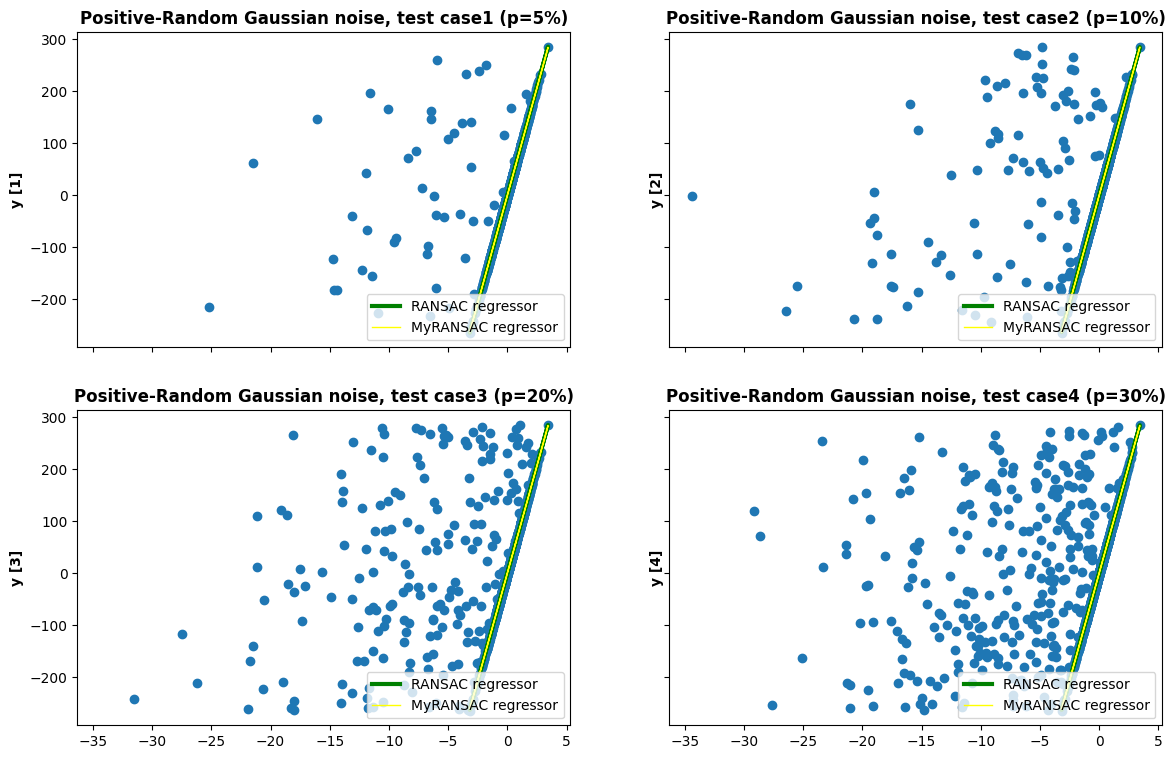

In [8]:
###################################################################################################
#Case 2: Random elements positively perturbed with a Gaussian noise
###################################################################################################
#Plotting
fig = plt.figure()    
fig, axs = plt.subplots(nrows = 2, ncols = 2, sharex=True, sharey = True, figsize=(14,9))
#Definition of X and y of noises
#################################################
#p=5%
X_noise1 = [[x_min + line_pos1[i]*diff_x + np.abs(normal_pos1[i])*x_n] for i in range(n_noise1)]
y_noise1 = [y_min + line_pos1[i]*diff_y + np.abs(normal_pos1[i])*y_n for i in range(n_noise1)]
#
X1 = np.append(X, X_noise1, axis = 0)
y1 = np.append(y, y_noise1, axis = 0)
#
line_X1 = np.array([x1[0] for x1 in X1])

##RANSAC##
#Robustly fit linear model with RANSAC algorithm
ransac1 = RANSACRegressor().fit(X1, y1)
inlier_mask1 = ransac1.inlier_mask_
outlier_mask1 = np.logical_not(inlier_mask1)

#MyRANSAC (from-scratch) training
myransac1 = MyRANSAC().fit(X1, y1)

# Predict data of estimated models
line_y_ransac1 = ransac1.predict(line_X1.reshape(-1, 1))
line_y_myransac1 = myransac1.predict(line_X1.reshape(-1, 1))

# Compare estimated coefficients
print("========================")
print("Coefficient1 Comparison ")
print("========================")
print("Coeff: ", coeff)
print("RANSAC (1) coefficient: ", ransac1.estimator_.coef_)
print("MyRANSAC (1) coefficient: ", myransac1.estimator_.coef_)

#Plot1
axs[0,0].scatter(line_X1, y1)
axs[0,0].set_title("Positive-Random Gaussian noise, test case1 (p=5%)",fontweight="bold")
axs[0,0].set_ylabel("y [1]",fontweight="bold")

#Plotting of RANSAC
axs[0,0].plot(
    line_X1[:n_samples],
    line_y_ransac1[:n_samples],
    color="green",
    linewidth=3,
    label="RANSAC regressor",
)
#Plotting of MyRANSAC
axs[0,0].plot(
    line_X1[:n_samples],
    line_y_myransac1[:n_samples],
    color="yellow",
    linewidth=1,
    label="MyRANSAC regressor",
)
axs[0,0].legend(loc="lower right")

#################################################
#p=10%
X_noise2 = [[x_min + line_pos2[i]*diff_x + np.abs(normal_pos2[i])*x_n] for i in range(n_noise2)]
y_noise2 = [y_min + line_pos2[i]*diff_y + np.abs(normal_pos2[i])*y_n for i in range(n_noise2)]
#
X2 = np.append(X, X_noise2, axis = 0)
y2 = np.append(y, y_noise2, axis = 0)
#
line_X2 = np.array([x2[0] for x2 in X2])

##RANSAC##
#Robustly fit linear model with RANSAC algorithm
ransac2 = RANSACRegressor().fit(X2, y2)
inlier_mask2 = ransac2.inlier_mask_
outlier_mask2 = np.logical_not(inlier_mask2)

#MyRANSAC (from-scratch) training
myransac2 = MyRANSAC().fit(X2, y2)

# Predict data of estimated models
line_y_ransac2 = ransac2.predict(line_X2.reshape(-1, 1))
line_y_myransac2 = myransac2.predict(line_X2.reshape(-1, 1))

# Compare estimated coefficients
print("========================")
print("Coefficient2 Comparison ")
print("========================")
print("RANSAC (2) coefficient: ", ransac2.estimator_.coef_)
print("MyRANSAC (2) coefficient: ", myransac2.estimator_.coef_)

#Plot2
axs[0,1].scatter(line_X2, y2)
axs[0,1].set_title("Positive-Random Gaussian noise, test case2 (p=10%)",fontweight="bold")
axs[0,1].set_ylabel("y [2]",fontweight="bold")

#Plotting of RANSAC
axs[0,1].plot(
    line_X2[:n_samples],
    line_y_ransac2[:n_samples],
    color="green",
    linewidth=3,
    label="RANSAC regressor",
)
#Plotting of MyRANSAC
axs[0,1].plot(
    line_X2[:n_samples],
    line_y_myransac2[:n_samples],
    color="yellow",
    linewidth=1,
    label="MyRANSAC regressor",
)
axs[0,1].legend(loc="lower right")

#################################################
#p=20%
X_noise3 = [[x_min + line_pos3[i]*diff_x + np.abs(normal_pos3[i])*x_n] for i in range(n_noise3)]
y_noise3 = [y_min + line_pos3[i]*diff_y + np.abs(normal_pos3[i])*y_n for i in range(n_noise3)]
#
X3 = np.append(X, X_noise3, axis = 0)
y3 = np.append(y, y_noise3, axis = 0)
#
line_X3 = np.array([x3[0] for x3 in X3])

##RANSAC##
#Robustly fit linear model with RANSAC algorithm
ransac3 = RANSACRegressor().fit(X3, y3)
inlier_mask3 = ransac3.inlier_mask_
outlier_mask3 = np.logical_not(inlier_mask3)

#MyRANSAC (from-scratch) training
myransac3 = MyRANSAC().fit(X3, y3)

# Predict data of estimated models
line_y_ransac3 = ransac3.predict(line_X3.reshape(-1, 1))
line_y_myransac3 = myransac3.predict(line_X3.reshape(-1, 1))

# Compare estimated coefficients
print("========================")
print("Coefficient3 Comparison ")
print("========================")
print("RANSAC (3) coefficient: ", ransac3.estimator_.coef_)
print("MyRANSAC (3) coefficient: ", myransac3.estimator_.coef_)

#Plot3
axs[1,0].scatter(line_X3, y3)
axs[1,0].set_title("Positive-Random Gaussian noise, test case3 (p=20%)",fontweight="bold")
axs[1,0].set_ylabel("y [3]",fontweight="bold")

#Plotting of RANSAC
axs[1,0].plot(
    line_X3[:n_samples],
    line_y_ransac3[:n_samples],
    color="green",
    linewidth=3,
    label="RANSAC regressor",
)
#Plotting of MyRANSAC
axs[1,0].plot(
    line_X3[:n_samples],
    line_y_myransac3[:n_samples],
    color="yellow",
    linewidth=1,
    label="MyRANSAC regressor",
)
axs[1,0].legend(loc="lower right")

#################################################
#p=30%
X_noise4 = [[x_min + line_pos4[i]*diff_x + np.abs(normal_pos4[i])*x_n] for i in range(n_noise4)]
y_noise4 = [y_min + line_pos4[i]*diff_y + np.abs(normal_pos4[i])*y_n for i in range(n_noise4)]
#
X4 = np.append(X, X_noise4, axis = 0)
y4 = np.append(y, y_noise4, axis = 0)
#
line_X4 = np.array([x4[0] for x4 in X4])

##RANSAC##
#Robustly fit linear model with RANSAC algorithm
ransac4 = RANSACRegressor().fit(X4, y4)
inlier_mask4 = ransac4.inlier_mask_
outlier_mask4 = np.logical_not(inlier_mask4)

#MyRANSAC (from-scratch) training
myransac4 = MyRANSAC().fit(X4, y4)

# Predict data of estimated models
line_y_ransac4 = ransac4.predict(line_X4.reshape(-1, 1))
line_y_myransac4 = myransac4.predict(line_X4.reshape(-1, 1))

# Compare estimated coefficients
print("========================")
print("Coefficient4 Comparison ")
print("========================")
print("RANSAC (4) coefficient: ", ransac4.estimator_.coef_)
print("MyRANSAC (4) coefficient: ", myransac4.estimator_.coef_)

#Plot4
axs[1,1].scatter(line_X4, y4)
axs[1,1].set_title("Positive-Random Gaussian noise, test case4 (p=30%)",fontweight="bold")
axs[1,1].set_ylabel("y [4]",fontweight="bold")

#Plotting of RANSAC
axs[1,1].plot(
    line_X4[:n_samples],
    line_y_ransac4[:n_samples],
    color="green",
    linewidth=3,
    label="RANSAC regressor",
)
#Plotting of MyRANSAC
axs[1,1].plot(
    line_X4[:n_samples],
    line_y_myransac4[:n_samples],
    color="yellow",
    linewidth=1,
    label="MyRANSAC regressor",
)
axs[1,1].legend(loc="lower right")

In this case of randomly adding noisy points, we observe from the tested cases that in each one of them, RANSAC ignores the outliers defined by these noisy points and trains the model considering the inliers only. 
Moreover, the coefficients of both the RANSAC and MYRANSAC algorithms are comparable (very close in all cases).

### Test 3: Perturbation equal to $p$% of points with lower $y$ coordinate

In this test, we will be using a 1000-point dataset (inline data from inclined linear model). Moreover, extra $p$ ($p=5\%$, $p=10\%$, $p=20\%$ and $p=30\%$) noisy points are added to the dataset. This perturbation is generated using a Gaussian noise, where the points are located at the lower-left part of the graph. For each generated dataset, the fitted lines obtained by using RANSAC and MYRANSAC are compared, as well as their coefficients.

Coefficient1 Comparison 
Coeff:  83.29434141611843
RANSAC (1) coefficient:  [83.08698929]
MyRANSAC (1) coefficient:  [82.75377858]
Coefficient2 Comparison 
RANSAC (2) coefficient:  [82.6181886]
MyRANSAC (2) coefficient:  [82.41294836]
Coefficient3 Comparison 
RANSAC (3) coefficient:  [82.06338311]
MyRANSAC (3) coefficient:  [81.84699996]
Coefficient4 Comparison 
RANSAC (4) coefficient:  [75.36533807]
MyRANSAC (4) coefficient:  [81.7550493]


<Figure size 640x480 with 0 Axes>

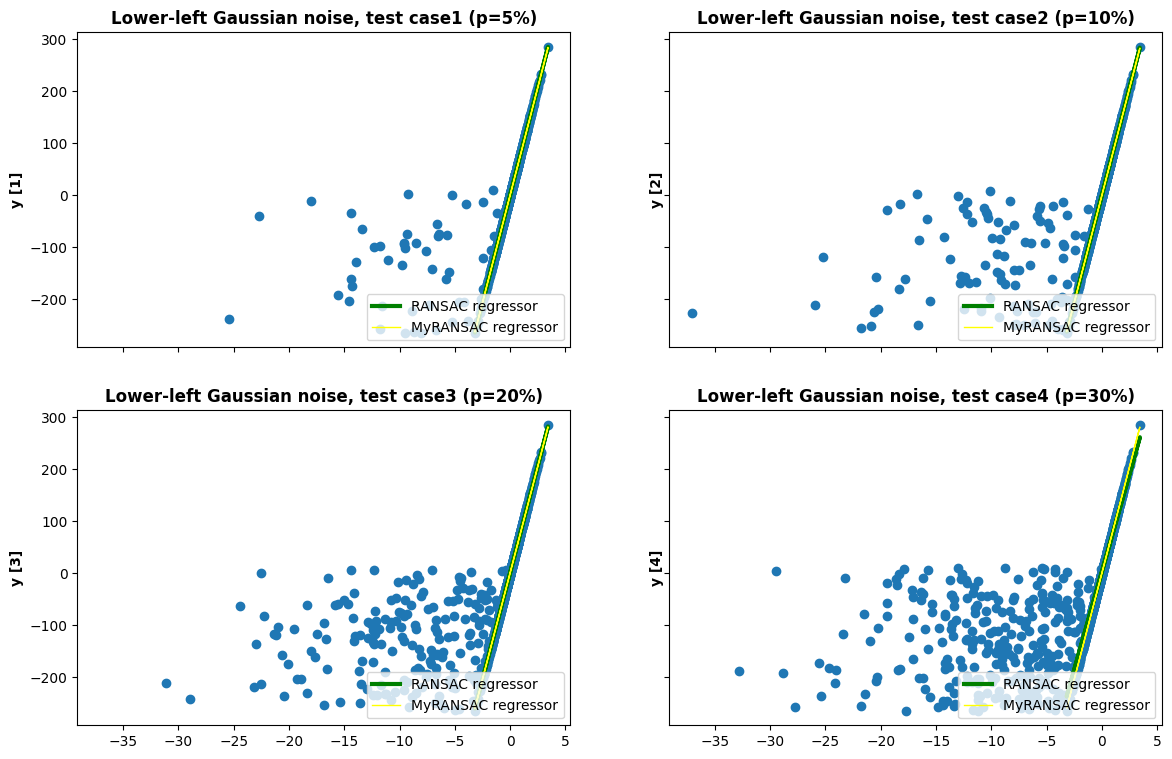

In [9]:
###################################################################################################
#Case 1: Random elements from dataset perturbed "sufficiently" with a Gaussian noise
###################################################################################################
#Line position
line_pos1 = np.random.uniform(0,0.5,n_noise1)
line_pos2 = np.random.uniform(0,0.5,n_noise2)
line_pos3 = np.random.uniform(0,0.5,n_noise3)
line_pos4 = np.random.uniform(0,0.5,n_noise4)

#Plotting
fig = plt.figure()    
fig, axs = plt.subplots(nrows = 2, ncols = 2, sharex=True, sharey = True, figsize=(14,9))
#Definition of X and y of noises
#################################################
#p=5%
X_noise1 = [[x_min + line_pos1[i]*diff_x + np.abs(normal_pos1[i])*x_n] for i in range(n_noise1)]
y_noise1 = [y_min + line_pos1[i]*diff_y + np.abs(normal_pos1[i])*y_n for i in range(n_noise1)]
#
X1 = np.append(X, X_noise1, axis = 0)
y1 = np.append(y, y_noise1, axis = 0)
#
line_X1 = np.array([x1[0] for x1 in X1])

##RANSAC##
#Robustly fit linear model with RANSAC algorithm
ransac1 = RANSACRegressor().fit(X1, y1)
inlier_mask1 = ransac1.inlier_mask_
outlier_mask1 = np.logical_not(inlier_mask1)

#MyRANSAC (from-scratch) training
myransac1 = MyRANSAC().fit(X1, y1)

# Predict data of estimated models
line_y_ransac1 = ransac1.predict(line_X1.reshape(-1, 1))
line_y_myransac1 = myransac1.predict(line_X1.reshape(-1, 1))

# Compare estimated coefficients
print("========================")
print("Coefficient1 Comparison ")
print("========================")
print("Coeff: ", coeff)
print("RANSAC (1) coefficient: ", ransac1.estimator_.coef_)
print("MyRANSAC (1) coefficient: ", myransac1.estimator_.coef_)

#Plot1
axs[0,0].scatter(line_X1, y1)
axs[0,0].set_title("Lower-left Gaussian noise, test case1 (p=5%)",fontweight="bold")
axs[0,0].set_ylabel("y [1]",fontweight="bold")

#Plotting of RANSAC
axs[0,0].plot(
    line_X1[:n_samples],
    line_y_ransac1[:n_samples],
    color="green",
    linewidth=3,
    label="RANSAC regressor",
)
#Plotting of MyRANSAC
axs[0,0].plot(
    line_X1[:n_samples],
    line_y_myransac1[:n_samples],
    color="yellow",
    linewidth=1,
    label="MyRANSAC regressor",
)
axs[0,0].legend(loc="lower right")

#################################################
#p=10%
X_noise2 = [[x_min + line_pos2[i]*diff_x + np.abs(normal_pos2[i])*x_n] for i in range(n_noise2)]
y_noise2 = [y_min + line_pos2[i]*diff_y + np.abs(normal_pos2[i])*y_n for i in range(n_noise2)]
#
X2 = np.append(X, X_noise2, axis = 0)
y2 = np.append(y, y_noise2, axis = 0)
#
line_X2 = np.array([x2[0] for x2 in X2])

##RANSAC##
#Robustly fit linear model with RANSAC algorithm
ransac2 = RANSACRegressor().fit(X2, y2)
inlier_mask2 = ransac2.inlier_mask_
outlier_mask2 = np.logical_not(inlier_mask2)

#MyRANSAC (from-scratch) training
myransac2 = MyRANSAC().fit(X2, y2)

# Predict data of estimated models
line_y_ransac2 = ransac2.predict(line_X2.reshape(-1, 1))
line_y_myransac2 = myransac2.predict(line_X2.reshape(-1, 1))

# Compare estimated coefficients
print("========================")
print("Coefficient2 Comparison ")
print("========================")
print("RANSAC (2) coefficient: ", ransac2.estimator_.coef_)
print("MyRANSAC (2) coefficient: ", myransac2.estimator_.coef_)

#Plot2
axs[0,1].scatter(line_X2, y2)
axs[0,1].set_title("Lower-left Gaussian noise, test case2 (p=10%)",fontweight="bold")
axs[0,1].set_ylabel("y [2]",fontweight="bold")

#Plotting of RANSAC
axs[0,1].plot(
    line_X2[:n_samples],
    line_y_ransac2[:n_samples],
    color="green",
    linewidth=3,
    label="RANSAC regressor",
)
#Plotting of MyRANSAC
axs[0,1].plot(
    line_X2[:n_samples],
    line_y_myransac2[:n_samples],
    color="yellow",
    linewidth=1,
    label="MyRANSAC regressor",
)
axs[0,1].legend(loc="lower right")

#################################################
#p=20%
X_noise3 = [[x_min + line_pos3[i]*diff_x + np.abs(normal_pos3[i])*x_n] for i in range(n_noise3)]
y_noise3 = [y_min + line_pos3[i]*diff_y + np.abs(normal_pos3[i])*y_n for i in range(n_noise3)]
#
X3 = np.append(X, X_noise3, axis = 0)
y3 = np.append(y, y_noise3, axis = 0)
#
line_X3 = np.array([x3[0] for x3 in X3])

##RANSAC##
#Robustly fit linear model with RANSAC algorithm
ransac3 = RANSACRegressor().fit(X3, y3)
inlier_mask3 = ransac3.inlier_mask_
outlier_mask3 = np.logical_not(inlier_mask3)

#MyRANSAC (from-scratch) training
myransac3 = MyRANSAC().fit(X3, y3)

# Predict data of estimated models
line_y_ransac3 = ransac3.predict(line_X3.reshape(-1, 1))
line_y_myransac3 = myransac3.predict(line_X3.reshape(-1, 1))

# Compare estimated coefficients
print("========================")
print("Coefficient3 Comparison ")
print("========================")
print("RANSAC (3) coefficient: ", ransac3.estimator_.coef_)
print("MyRANSAC (3) coefficient: ", myransac3.estimator_.coef_)

#Plot3
axs[1,0].scatter(line_X3, y3)
axs[1,0].set_title("Lower-left Gaussian noise, test case3 (p=20%)",fontweight="bold")
axs[1,0].set_ylabel("y [3]",fontweight="bold")

#Plotting of RANSAC
axs[1,0].plot(
    line_X3[:n_samples],
    line_y_ransac3[:n_samples],
    color="green",
    linewidth=3,
    label="RANSAC regressor",
)
#Plotting of MyRANSAC
axs[1,0].plot(
    line_X3[:n_samples],
    line_y_myransac3[:n_samples],
    color="yellow",
    linewidth=1,
    label="MyRANSAC regressor",
)
axs[1,0].legend(loc="lower right")

#################################################
#p=30%
X_noise4 = [[x_min + line_pos4[i]*diff_x + np.abs(normal_pos4[i])*x_n] for i in range(n_noise4)]
y_noise4 = [y_min + line_pos4[i]*diff_y + np.abs(normal_pos4[i])*y_n for i in range(n_noise4)]
#
X4 = np.append(X, X_noise4, axis = 0)
y4 = np.append(y, y_noise4, axis = 0)
#
line_X4 = np.array([x4[0] for x4 in X4])

##RANSAC##
#Robustly fit linear model with RANSAC algorithm
ransac4 = RANSACRegressor().fit(X4, y4)
inlier_mask4 = ransac4.inlier_mask_
outlier_mask4 = np.logical_not(inlier_mask4)

#MyRANSAC (from-scratch) training
myransac4 = MyRANSAC().fit(X4, y4)

# Predict data of estimated models
line_y_ransac4 = ransac4.predict(line_X4.reshape(-1, 1))
line_y_myransac4 = myransac4.predict(line_X4.reshape(-1, 1))

# Compare estimated coefficients
print("========================")
print("Coefficient4 Comparison ")
print("========================")
print("RANSAC (4) coefficient: ", ransac4.estimator_.coef_)
print("MyRANSAC (4) coefficient: ", myransac4.estimator_.coef_)

#Plot4
axs[1,1].scatter(line_X4, y4)
axs[1,1].set_title("Lower-left Gaussian noise, test case4 (p=30%)",fontweight="bold")
axs[1,1].set_ylabel("y [4]",fontweight="bold")

#Plotting of RANSAC
axs[1,1].plot(
    line_X4[:n_samples],
    line_y_ransac4[:n_samples],
    color="green",
    linewidth=3,
    label="RANSAC regressor",
)
#Plotting of MyRANSAC
axs[1,1].plot(
    line_X4[:n_samples],
    line_y_myransac4[:n_samples],
    color="yellow",
    linewidth=1,
    label="MyRANSAC regressor",
)
axs[1,1].legend(loc="lower right")

In this case of randomly adding noisy points, we observe from the tested cases that in each one of them, RANSAC ignores the outliers defined by these noisy points and trains the model considering the inliers only. 
Moreover, the coefficients of both the RANSAC and MYRANSAC algorithms are comparable (very close in all cases).

### Conclusions

RANSAC algorithm aims at a robust estimation of large-dataset models. It assumes that the data training is only dependent on the inliers and thus ignores the outliers. So, in short, RANSAC is robust against the outliers, performant and easy to implement. However, it requires prior knowledge about data. Additionally, the number of iterations increase logarithmically with the outliers [6](https://sdg002.github.io/ransac-circle/index.html).  

 #### References:

[1] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html

[2] https://fr.wikipedia.org/wiki/RANSAC

[3] https://en.wikipedia.org/wiki/Median_absolute_deviation

[4] https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py

[5] https://www.baeldung.com/cs/ransac

[6] https://sdg002.github.io/ransac-circle/index.html

## Exercise 2: <a id='ex2'></a>

### Part 1 : 

In the first part of the exercise, we assume to have a cloud of data points that we want to estimate their center in an efficient way using the RANSAC algorithm. The RANSAC algorithm given in exercise 1 is updated as the following:
1. Same as previous exercise, we select randomly a subset from the dataset,
2. In this case, we don't have regression model. The candidate model is substituted by the computation of the average point in the selected subset,
3. We compute the distance between all points of the dataset and the estimated center. If this distance is smaller than a threshold, the point will be considered as "inlier". 
4. We compute again the average center of all the inliers,
5. To score the estimated center, we compute its distance from the median center of inliers. We keep track of the center giving the smaller ditance,
6. Go back to step 1 and stop the algorithm when the maximum number of iteration is reached. 

In [12]:
# Load the required libraries
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn import datasets
import matplotlib.pyplot as plt

In [37]:
# Compute the distance between two points
squared_dist = lambda pt1, pt2: sum([(pt1[i]-pt2[i])**2 for i in range(len(pt1))])

# Compute the average point in a dataset
get_average_point = lambda points: np.array([np.mean([pt[i] for pt in points]) for i in range(len(points[0]))])

# Compute the median point in a dataset
get_median_point = lambda points: np.array([np.median([pt[i] for pt in points]) for i in range(len(points[0]))])


def compute_error(points,center):
    """
    Compute an error which evaluate the "centricity" of a point in the dataset.
    It is the distance between the point center an the "median point" of the dataset

    Parameters
    ----------
    points : Array_like
        Dataset.
    center : Array_like
        The point that need to be evaluated.

    Returns
    -------
    z : float
        The error defined as the distance between center and the "median point" of the dataset.

    """
    median = get_median_point(points)
    return squared_dist(center, median)

def RANSAC_center(dataset, n_steps=1000, nb_samples=None, threshold=None):
    """
    Compute the center of a dataset based on a proposed RANSAC algorithm.

    Parameters
    ----------
    dataset : Array_like
        Points cloud.
    n_steps : int, optional
        Number of iterations. The default is 1000.
    nb_samples : int, optional
        Number of simples to be chosen randomly from the dataset. The default is None.
    threshold : float, optional
        A threshold to assess if a point can be considerd as inlier.
        If not specified, it will be set as the Median Absolute Deviation of the maximal distances between each pair of points

    Returns
    -------
    bestCenter : Array_like
        Coordinates of the determined center of the dataset by the algorithm.

    """
    
    if nb_samples == None:
        nb_samples = points.shape[1]+1
    best_error = np.inf
    # Set threshold if not specified by the user
    if threshold == None:
        max_distances = [np.max([np.sqrt(squared_dist(pt1,pt2)) for pt2 in dataset]) for pt1 in dataset]
        median_dist = np.median(max_distances)
        threshold = np.median([np.abs(dist-median_dist) for dist in max_distances])
        threshold *= threshold
    # Start iterations
    for i in range(n_steps):
        # Select randomly nb_samples from trhe dataset
        rand_indices = np.random.choice(range(len(dataset)), size=nb_samples)
        maybeInliers = [dataset[i] for i in rand_indices]
        # Estimate the center based on the selected inliers
        maybeCenter = get_average_point(maybeInliers)
        # Check all the points.
        # If the distance between the point and maybeCenter is smaller than the threshold, it will be considered is inlier
        maybeInliers = []
        for point in dataset:
            if squared_dist(maybeCenter,point) < 3*threshold:
                maybeInliers.append(point)
        
        if len(maybeInliers) > 1:
            # Evaluate again the center baced on the new inliers
            maybeCenter = get_average_point(maybeInliers)
            # Compute an error and save the center if it is smaller than the best center
            error = compute_error(maybeInliers,maybeCenter)
            if error < best_error:
                bestCenter = maybeCenter
    return bestCenter

We tested the proposed algorithm on a dataset composed of a main Gaussian and a random noise, generated as the following:

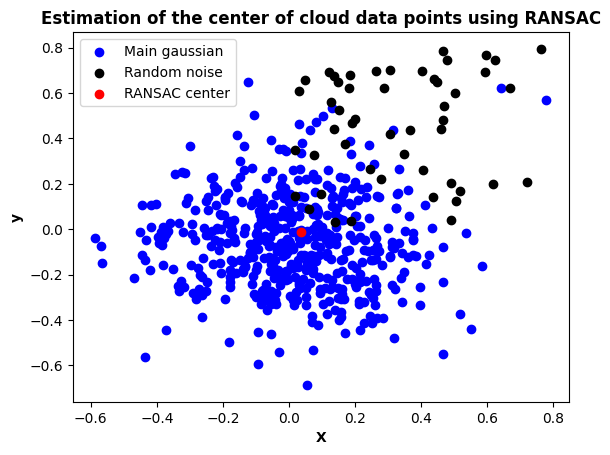

In [38]:
### Generation of the dataset ###

sigma = 0.2 # standard deviation

# Generate a gaussian as the 'main' dataset
points, labels = datasets.make_blobs(n_samples=500, cluster_std=sigma, centers=1, center_box=(-0.1, 0.1), random_state=100)

# Generate random noise around the main gaussian
noise = np.random.rand(50, 2)*4*sigma

dataset = np.append(points,noise, axis=0)

### Compute the center by different ways ###

# center computed by RANSAC algorithm
ransac_center = RANSAC_center(dataset, threshold=sigma)

figa = plt.scatter(points[:,0],points[:,1],c='b') # label: main gaussian
figb = plt.scatter(noise[:,0],noise[:,1],c='k') # label: random noise
figc = plt.scatter([ransac_center[0]],[ransac_center[1]], marker='o', c='r') # RANSAC center
plt.xlabel("X",fontweight="bold")
plt.ylabel("y",fontweight="bold")
plt.title("Estimation of the center of cloud data points using RANSAC",fontweight="bold")
plt.legend(["Main gaussian", "Random noise", "RANSAC center"])

One can see from the figure above that the center of the cloud data points is well estimated (in red) using RANSAC. In matter of fact, the outliers (in black) are ignored, while the data is trained (estimation of the center) on the inliers (blue). 

Maybe there are better ways to estimate the center of the cloud and also to evaluate its "centricity" in a cloud data points. Moreover, we may need better stopping criteria.

#### Part 2:

In the second part, we applied the k-means clustering algorithm. Instead of computing the "means" as the average of the points cluster, we used the previous RANSAC center search function. 

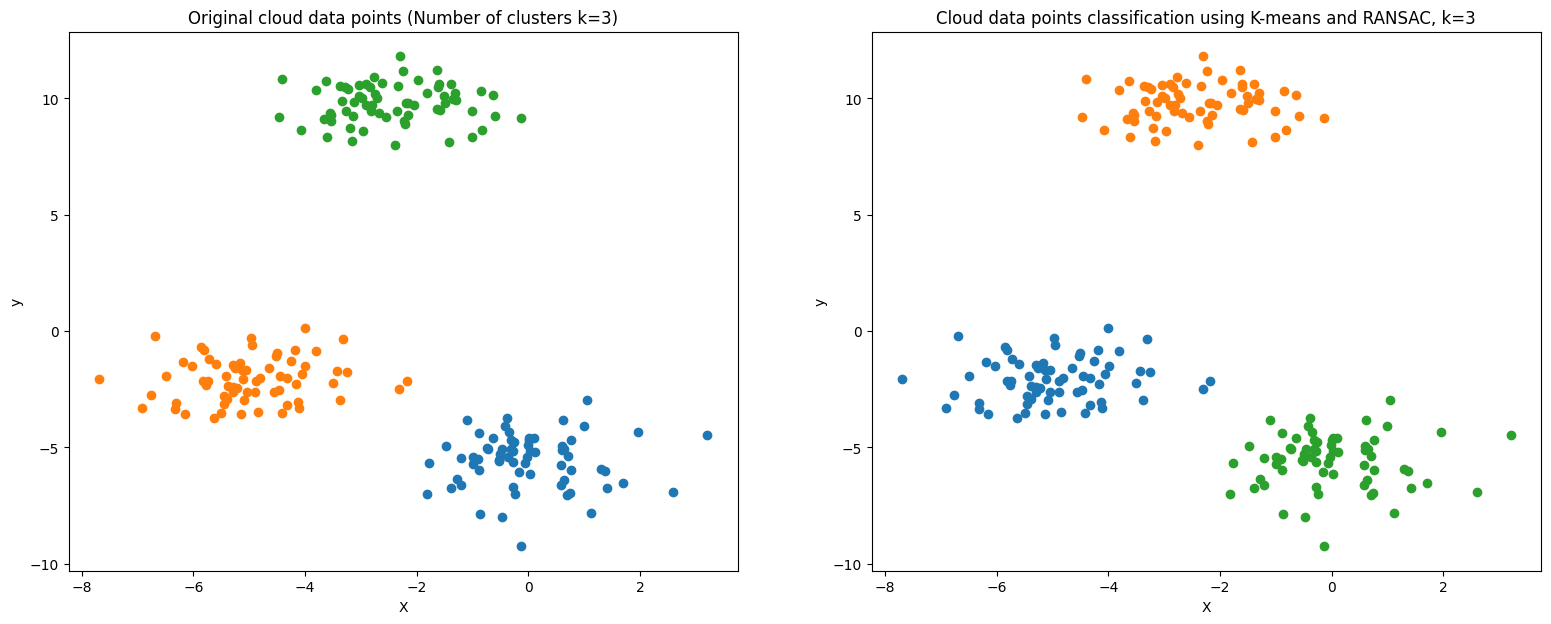

<Figure size 640x480 with 0 Axes>

In [39]:
#### Compute the centers of k-clusters using k-means ####

# Generate the dataset: 2 gaussians with the same standard deviation
sigma = 1 # standard deviation
k = 3 # number of clusters
Points, true_labels = datasets.make_blobs(n_samples=200, centers=k, cluster_std=sigma, random_state=50)
 
#### k-means with RANSAC ####
N = len(Points) # size of the input points

# Initialize the the k means randomly between the input points
means_idx = np.random.uniform(0,N-1,k)
means = [Points[int(idx)] for idx in means_idx]

labels = [0 for i in range(N)]
converged = False
while not converged:
    converged = True
    for pt_idx, pt in enumerate(Points):
        min_dist = float('+inf')
        for mean_idx, mean in enumerate(means):
            dist = squared_dist(pt,mean)
            if dist < min_dist:
                min_dist, best_idx = dist, mean_idx
        if labels[pt_idx] != best_idx:
            converged = False
            labels[pt_idx] = best_idx
            
    # Recompute means
    for mean_idx in range(k):
        cluster = [pt for idx, pt in enumerate(Points) if labels[idx] == mean_idx]
        if len(cluster) > 0:
            means[mean_idx] = RANSAC_center(cluster, n_steps=100, threshold=sigma)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19,7))
plt.figure()
for g in np.unique(true_labels):
    i = np.where(true_labels == g)
    ax1.scatter(Points[i,0], Points[i,1], label=g)
    ax1.set_xlabel("X")
    ax1.set_ylabel("y")
    ax1.set_title("Original cloud data points (Number of clusters k=3)")
    
#plt.figure()
for g in np.unique(labels):
    i = np.where(labels == g)
    ax2.scatter(Points[i,0], Points[i,1], label=g)
    ax2.set_xlabel("X")
    ax2.set_ylabel("y")
    ax2.set_title("Cloud data points classification using K-means and RANSAC, k=3")

In this particular example, the k-means and RANSAC algorithm succeeded in the good clustering of the data points.

#### Question (c) : Could you imagine other applications? 

Another applications of the RANSAC algorithm could be:
* The point cloud data segmentation as explained in [1](https://www.researchgate.net/publication/337689706_Point_Cloud_Data_Segmentation_Using_RANSAC_and_Localization). 
* The comparison and correspondence between two pictures using the center points of the objects constituting it, like in [2](https://cmp.felk.cvut.cz/~chum/papers/chum-accv04.pdf). 

#### Question (d) : Pseudocode of the generalization of RANSAC for arbitrary learning problems

For an arbitary learning problem, the RANSAC algorithm can be generalized in order to estimate a model feature. The importance steps are the following:
1. Selecting randomly subset of the input data,
2. Definition of "training" methodology. The training does not necessarily means complicated algorithms. We just need a first estimation of the model,
3. Definition of threshold and an error measurement function that assess how good the estimated model in the entire dataset,
4. The data samples considered relevant by the estimated model are re-used again to estimate a better model,
5. The accuracy of the model should be evaluated,
6. Finally, we choose the model with the best accuracy.

## Exercise 3:  <a id='ex3'></a>

The time-series regression modeled in this exercise consists in predicting the future behaviour of a series based on its historical behaviour. The *AutoReg* model is chosen for this task. After the train/test split and the model training, one should evaluate its performance. This could be done using the *train-test-split* method, where only a small part of the data is used as a testet. However, this method is penalized by some limitations that will be investigated in this work. Another method is the *cross-validation*, which can provide a more reliable error estimation, a crucial step to evaluate the model and choose the optimized input parameters.

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pip install statsmodels --upgrade
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

### Description of the dataset

A time-series (dataframe) illustrating the monthly variation of the closed-deals as a function of the sales period (from "$2013-10-01$" till "$2021-12-01$") is considered as the dataset, initially introduced in a *".cvs"* file format from the *GitHub* project repository [1](https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html), and was generated using a sinus function and some random noises. 

In [3]:
#Import time-series dataset from GitHub (Read times in date format)
data_url = 'https://raw.githubusercontent.com/Chaichas/Project/main/DataSales_autoreg.csv'
dataset = pd.read_csv(data_url, sep=',',index_col=0, parse_dates=True)
dataset = dataset.asfreq('MS') #frequency

Text(0, 0.5, 'Closed deals')

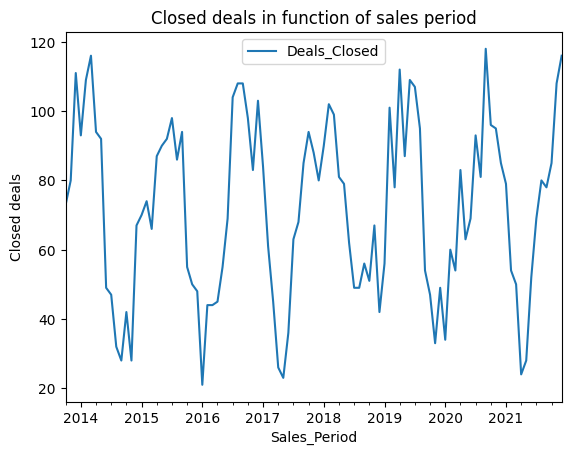

In [4]:
#Extracting the output (closed deals) from the dataset
output_dataset = dataset.values
dataset.plot(title='Closed deals in function of sales period')
plt.ylabel("Closed deals")

### Times-series Modelling using AutoReg

The **AutoReg model for Time Series Forecasting** will be used in this section to predict the monthly closed deals for the future sales periods, based on the previous values. 

Generally speaking, a **regression model** is a modeling of the predicted value (output) using a combination of the input varaibales [2](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/). It can also be used on a **time-series** (represented by ordered events in time), where we train past observations (at earlier time periods), the so-called "lags", and use *autocorrelation* to find a relation between data at close time steps [3](https://vitalflux.com/autoregressive-ar-models-with-python-examples/) in order to predict the future. 

Using the following **autoregression model** equation: 

$\boxed{y(t) = b_0 + b_1 \; y(t-1) + b_2 \; y(t-2) }\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \mathbf{(\text{Eq.} \; (3.1))}$ 

where: $b_0$ and $b_1$ are optimized coefficients following the model training, one can see that the prediction of the future-value $y(t)$ is done based on both values $y(t-1)$ and $y(t-2)$ at previous time periods $(t-1)$ and $(t-2)$. The **autoregression model** is therefore a trained regression model used to predict the response future variable based on its own past values. 

For instance, since the time lag is monthly, the values $y(t-1)$ and $y(t-2)$ represent the values of $y$ in the previous and before-previous months. The number of lags is a fixed constant and represents the number of time lags while training the AutoReg model [3](https://vitalflux.com/autoregressive-ar-models-with-python-examples/). 

A general case of the previous autoregression model equation, with $p$ number of time lags would be:

$\boxed{y(t) = b_0 + b_i \; y(t-i) \text{, where } i \in [1,p]} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \mathbf{(\text{Eq.} \; (3.2))}$

In what follows, the input dataset is split into trainset ($79.79\%$ of the total data) and testset ($20.20\%$ of the total data). The AutoReg model is then used to train the data, using a fixed value of lags equal to $10$. 

In [5]:
#Splitting the dataset into train and test data (we can also use the train_test_split function :) )
#split_val represents the number of data values considered for test (20 samples)
split_val = 20
trainset = dataset[:-split_val]
testset = dataset[-split_val:]
print("Trainset shape: ", trainset.shape, ", Testset shape: ", testset.shape)
print("Train data (%): ", 100-(testset.shape[0]/(trainset.shape[0] + testset.shape[0])*100), ", Test data (%): ", 100*testset.shape[0]/(trainset.shape[0] + testset.shape[0]))

Trainset shape:  (79, 1) , Testset shape:  (20, 1)
Train data (%):  79.79797979797979 , Test data (%):  20.2020202020202


                            AutoReg Model Results                             
Dep. Variable:           Deals_Closed   No. Observations:                   79
Model:                    AutoReg(10)   Log Likelihood                -270.465
Method:               Conditional MLE   S.D. of innovations             12.193
Date:                Mon, 31 Oct 2022   AIC                            564.930
Time:                        11:13:27   BIC                            591.740
Sample:                    08-01-2014   HQIC                           575.567
                         - 04-01-2020                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              105.7894     18.928      5.589      0.000      68.692     142.887
Deals_Closed.L1      0.3034      0.121      2.511      0.012       0.067       0.540
Deals_Closed.L2      0.2380 

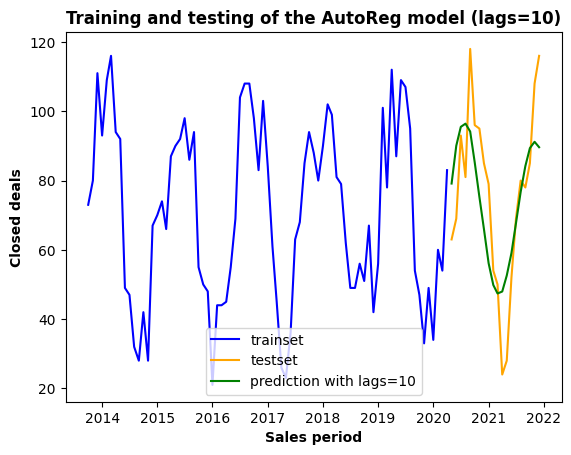

In [8]:
#Applying and training the autoregression model [1]
Autoreg_model = AutoReg(trainset,lags=10).fit()
print(Autoreg_model.summary())

#Prediction (on the testset)
prediction10 = Autoreg_model.predict(start=len(trainset),end=len(output_dataset)-1)

#Plotting
plt.figure()
plt.plot(trainset, 'b', label='trainset')
plt.plot(testset, 'orange', label='testset')
plt.plot(prediction10, 'g', label='prediction with lags=10')
plt.title("Training and testing of the AutoReg model (lags=10)",fontweight="bold")
plt.xlabel("Sales period",fontweight="bold")
plt.ylabel("Closed deals",fontweight="bold")
plt.legend()

From the above figure, one can clearly see that the model can predict relatively well. The predicted values (in green) are reconstructed with a smoothing curve. However, a question arises here: What's the influence of the parameter "lags" on the prediction? 

In what follows, the effects of the lags value variation on the AutoReg predicted data will be investigated.

### Effect of the lags in the AutoReg model

Text(0, 0.5, 'Closed deals')

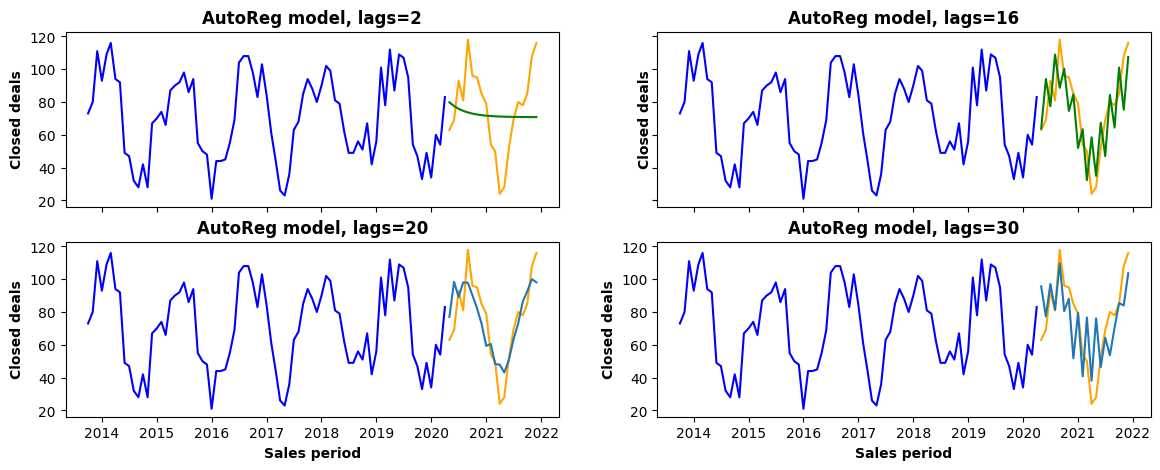

In [226]:
#The effect of the lags parameter variation on the predictions
###################################################################################################
#with lags=2
###################################################################################################
Autoreg_model = AutoReg(trainset,lags=2).fit()
prediction2 = Autoreg_model.predict(start=len(trainset),end=len(output_dataset)-1)
#Plotting (lags=2)
fig, axs = plt.subplots(2, 2, figsize=(14,5))
axs[0, 0].plot(trainset, 'b', label='trainset')
axs[0, 0].plot(testset, 'orange', label='trainset')
axs[0, 0].plot(prediction2, 'g', label="prediction with lags=2")
axs[0, 0].set_title("AutoReg model, lags=2",fontweight="bold")
# axs[0, 0].set_xlabel("Sales period",fontweight="bold")
axs[0, 0].label_outer() #Hide x-axis
axs[0, 0].set_ylabel("Closed deals",fontweight="bold")
# axs[0, 0].legend()

###################################################################################################
#with lags=16
###################################################################################################
Autoreg_model = AutoReg(trainset,lags=16).fit()
prediction16 = Autoreg_model.predict(start=len(trainset),end=len(output_dataset)-1)
#Plotting (lags=16)
axs[0, 1].plot(trainset, 'b', label='trainset')
axs[0, 1].plot(testset, 'orange', label='trainset')
axs[0, 1].plot(prediction16, 'g', label="prediction with lags=16")
axs[0, 1].set_title("AutoReg model, lags=16",fontweight="bold")
# axs[0, 1].set_xlabel("Sales period",fontweight="bold")
axs[0, 1].label_outer() #Hide x-axis
axs[0, 1].set_ylabel("Closed deals",fontweight="bold")
# axs[0, 1].legend()

###################################################################################################
#with lags=20
###################################################################################################
Autoreg_model = AutoReg(trainset,lags=20).fit()
prediction20 = Autoreg_model.predict(start=len(trainset),end=len(output_dataset)-1)
#Plotting (lags=20)
axs[1, 0].plot(trainset, 'b', label='trainset')
axs[1, 0].plot(testset, 'orange', label='trainset')
axs[1, 0].plot(prediction20, label="prediction with lags=20")
axs[1, 0].set_title("AutoReg model, lags=20",fontweight="bold")
axs[1, 0].set_xlabel("Sales period",fontweight="bold")
axs[1, 0].set_ylabel("Closed deals",fontweight="bold")
# axs[1, 0].legend()

###################################################################################################
#with lags=30
###################################################################################################
Autoreg_model = AutoReg(trainset,lags=30).fit()
prediction30 = Autoreg_model.predict(start=len(trainset),end=len(output_dataset)-1)
#Plotting (lags=30)
axs[1, 1].plot(trainset, 'b', label='trainset')
axs[1, 1].plot(testset, 'orange', label='trainset')
axs[1, 1].plot(prediction30, label="prediction with lags=30")
axs[1, 1].set_title("AutoReg model, lags=30",fontweight="bold")
axs[1, 1].set_xlabel("Sales period",fontweight="bold")
axs[1, 1].set_ylabel("Closed deals",fontweight="bold")
# axs[1, 1].legend()

From the above figures, one can conduct the following:
* `lags = 2:` We obtain a bad prediction, which is distant from the original time-series shape,
* `lags = 16:`  We obtain a relatively good prediction, which has the shape of the original time-series. Moreover, some noise are predicted. One can conclude that by increasing the lags parameters from $2$ to $16$, we capture more features of the dataset. 
* `lags = 20:` The general data shape is captured. However, the prediction is nor too smooth, nor too noisy. Maybe we are getting closer to the perfect model?
* `lags = 30:` The prediction here is too noisy.

Which lags value shall we use? To answer this question, we have to evaluate quantitatively the models. Therefore, we measured the variance with respect to the original testset. In what follows, the mean squarred error of the prediction values using specific lags parameters (varying from $0$ to $29$) are computed. 

Text(0.5, 1.0, 'Error yielded by the variation of lags in AutoReg model')

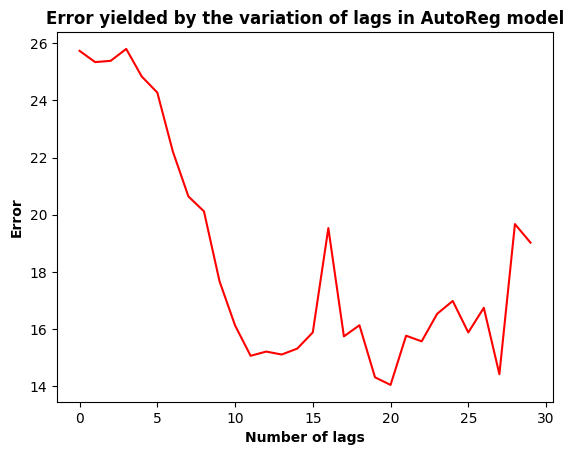

In [231]:
#Plotting of the prediction error in function of lags variation
error_lag = []
for lags in range (30):
    Autoreg_model = AutoReg(trainset,lags=lags).fit()
    prediction = Autoreg_model.predict(start=len(trainset),end=len(output_dataset)-1)
    error_lag.append(np.sqrt(mean_squared_error(testset,prediction)))
plt.figure()
plt.plot(error_lag,'r')
plt.xlabel('Number of lags',fontweight="bold")
plt.ylabel('Error',fontweight="bold")
plt.title('Error yielded by the variation of lags in AutoReg model',fontweight="bold")

From the above figure, one can see that the error depends on the choice of the lags parameter of the AutoReg model. The choice of a the model parameter can be appropriate for a certain trainset, but it is not always straightforward to conclude about its generality. In the section here-under, we will be using the **cross-validation** approachs (*trainse/testset split* and *K-Fold*) in order to evaluate the AutoReg model performance. 

### Modeling using Cross Validation

The **cross-validation :** Giving a dataset, this latter should be split into a trainset and a testset in order to avoid any overfitting problem by using the same data for training and testing. The following diagram summarizes a machine learning problem. 

<!-- 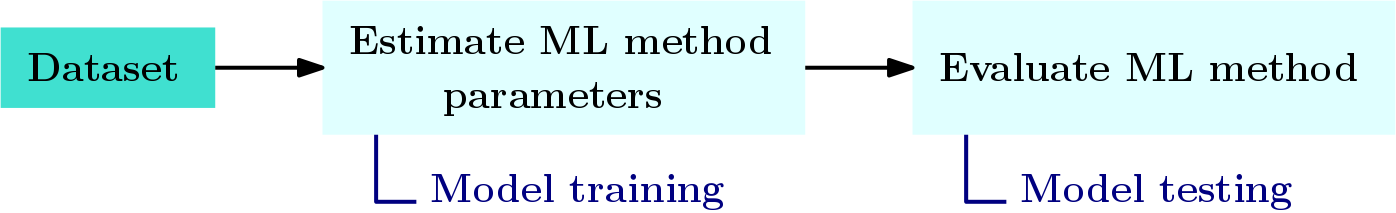 -->
<div>
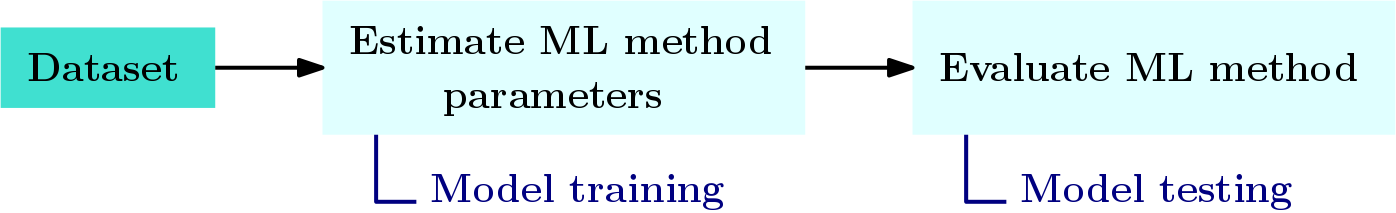
</div>

**Figure 3.1: Splitting the dataset in a machine learning problem.**

Nevertheless, the random split of the trainset/testset may not be fully representative of the time-series. To avoid such a problem, we can use the cross-validation (cv) [4](https://scikit-learn.org/stable/modules/cross_validation.html). The principle of this method consists in splitting the train data into $k$ blocks (or folds): $(k-1)$ blocks to train the model and one block to test it. A final evaluation using the testset is then performed. Next, it switches to other blocks for training and testing. At the end, every block of the data is used for the training and evaluated using the remaining data. This cross-validation method is called *k-fold cross-validation*.  Figure (3.2) summarizes the *k-folded* approach of cv. The performance of this approach is the mean of the accuracies obtained using the different blocks.

<!-- 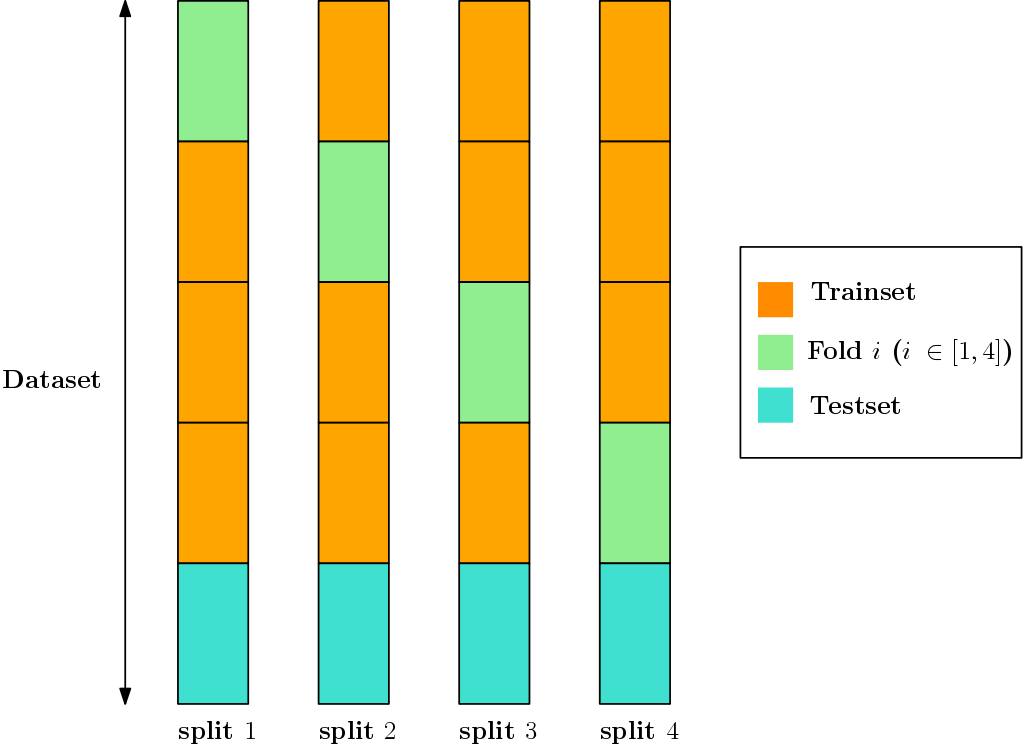 -->
<div>
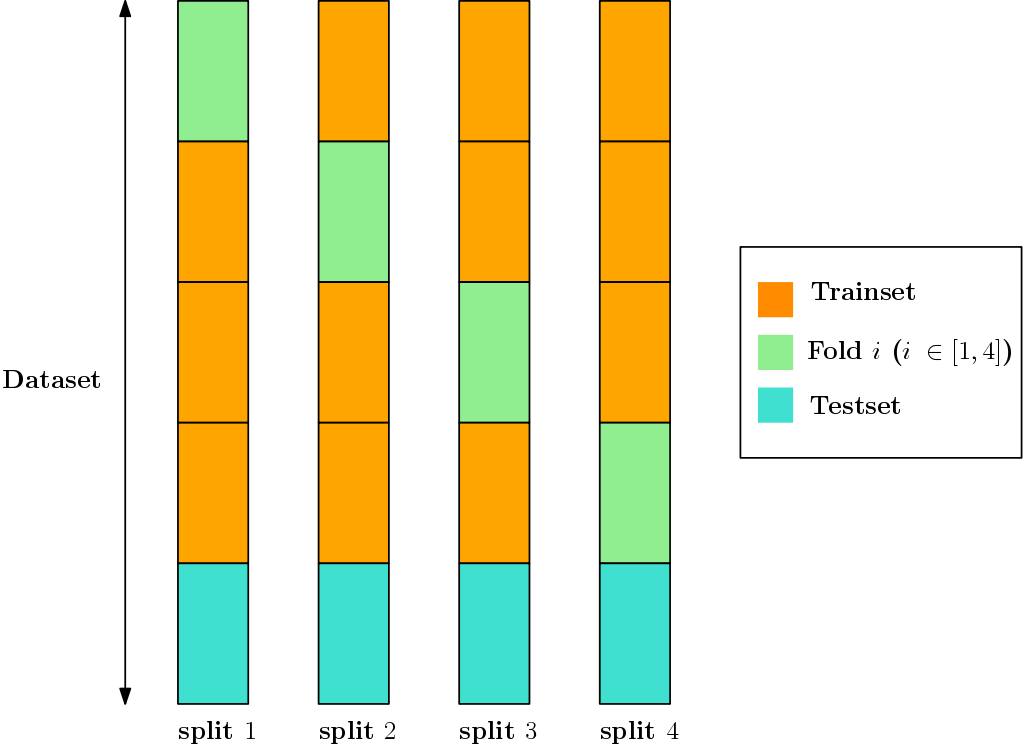
</div>

**Figure 3.2: Illustration of a 4-folded cross-validation approach (k=4).**

The **TimeSeriesSplit** function is also a time-ordered variation of the **K-fold** approach and splits the time-series data at fixed time steps. In each split, we use the previous data to train the model, whereas the data following the selected trainset are reserved for testing (still in the past though). In other terms, we use $k$ folds for the model training and the $(k+1)^{th}$ fold to test it [5](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), as illustrated in figure (3.3).

<!-- 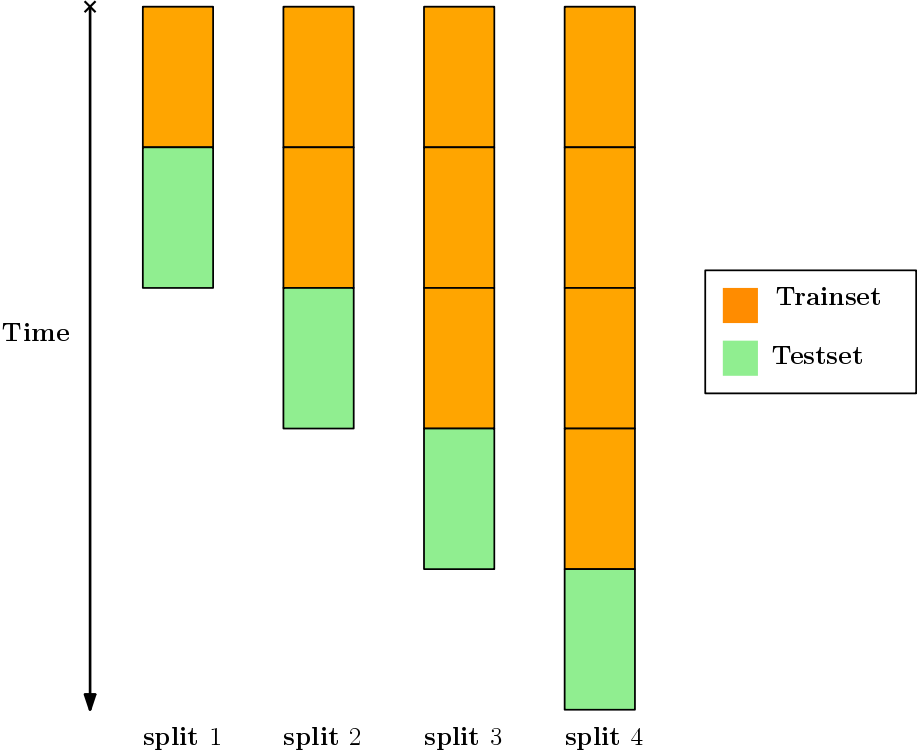 -->
<div>
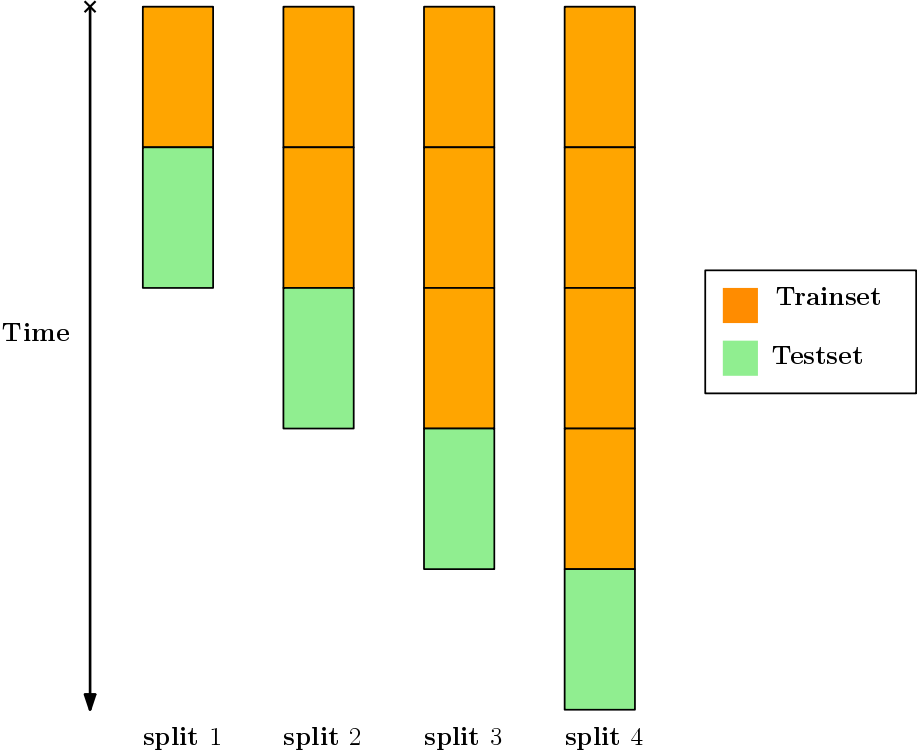
</div>

**Figure 3.3: Illustration of The TimeSeriesSplit (k=4).**

In what follows, the TimeSeriesSplit function is used to split the time-series, where the number of splits is equal to $4$. The prediction error is then evaluated for each split according to the variation of the number of lags of the AutoReg model.

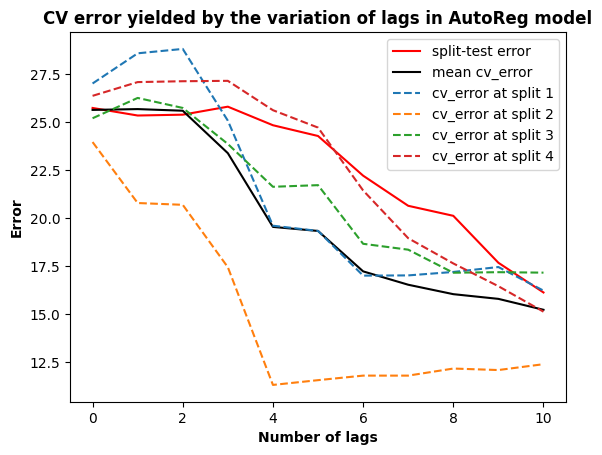

In [236]:
#Train/test indexes to split the dataset (time-series)
n_splits = 4 #number of folds k
TimeSeries_CrossValidation = TimeSeriesSplit(n_splits)

#Error estimation using cross validation: applied to the whole dataset
tot_lags = 11
mean_error = []
error_cv = []

for lag in range(tot_lags):
    lag_error_cv = []
    for idx_trainset, idx_testset in TimeSeries_CrossValidation.split(dataset):
        #Splitting dataset to train/test data using TimeSeriesSplit
        trainset_crossValidation,testset_crossValidation= dataset.iloc[idx_trainset],dataset.iloc[idx_testset]
#         print("\n *FOLD {nb}*".format(nb=fold))
#         print("Train indices:", idx_trainset, "Test indices:", idx_testset) 
#         print("Trainset:", trainset_crossValidation)
#         print("Testset:", testset_crossValidation)

        #Autoregression model application for each fold
        Autoreg_model = AutoReg(trainset_crossValidation,lags=lag).fit()

        #Prediction
        prediction=Autoreg_model.predict(start=len(trainset_crossValidation),end=len(trainset_crossValidation)+len(testset_crossValidation)-1)

        #Prediction error
        lag_error_cv.append(np.sqrt(mean_squared_error(testset_crossValidation.values, prediction.values)))

    error_cv.append(lag_error_cv)
    mean_error.append(np.mean(lag_error_cv))

splits_error = [[error_cv[i][j] for i in range(tot_lags)] for j in range(len(error_cv[0]))]

#Plotting of the errors
plt.figure()
plt.plot(error_lag[:tot_lags],'r',label='split-test error')
plt.plot(mean_error,'k',label='mean cv_error')
for split in range(len(splits_error)):
    plt.plot(splits_error[split],'--',label='cv_error at split '+str(split+1))
plt.xlabel('Number of lags',fontweight="bold")
plt.ylabel('Error',fontweight="bold")
plt.title('CV error yielded by the variation of lags in AutoReg model',fontweight="bold")
plt.legend()

From the above figure, one can notice that the mean cross-validation error is generally lower than the error obtained by the random train/test split method. It is also interesting to compare the errors of the different splits for this given dataset. The last split (nb_split=4) has an error curve varying in function of the number of lags close to the train/test split method, which is expected. The error measured with the second split is quite different from the others, which confirms the statement that the model training depends on the portion of the dataset chosen for this task. The plot of the different split errors highlight the importance of the cross-validation method to evaluate the model performance and overcomes the problem of randomly splitting the dataset into trainset and testset.

Finally, let us deduce the following simple $\large{\mathbf{\underline{pseudocode}}}$:

* Import a time-series dataset (output variable varying in function of time-fixed interval values)
* Define a certain number of splits (for example $n\_split = 4$)
* Split data in such a way that for every split $i$, where $i \in [1,n\_split]$:
   *  i folds are used for training
   *  The next $(i+1)^{th}$ fold is used for testing
   *  In each split, train the model (for example: use the AutoReg model) on the trainset
   *  Evaluate the model using the performance metrics (prediction according to testset, prediction in the future, accuracy)

### Conclusions

The **cross-validation** model offers two main advantages:
* The evaluation of the machine learning model: How well do they categorize testset?
* The search of the best values to estimate tuning parameters. 

It could also be used for time-series models to avoid the random split of trainset/testset (k-folded time-series split), and thus gives a better evaluation of the model (prediction error, accuracy). However, it is penalized by the fact that using the k-fold approach, the model is trained $k$ times, which is not optimal in machine learning since it requires important computational ressources (such as computation time).

 #### References:
 
 [1] https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html
 
 [2] https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
 
 [3] https://vitalflux.com/autoregressive-ar-models-with-python-examples/
 
 [4] https://scikit-learn.org/stable/modules/cross_validation.html
 
 [5] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

## Exercise 4 :  <a id='ex4'></a>

Before digging into the exercise, two important concepts must be briefly introduced:

**Support vector machines (SVMs):** Supervised learning methods using classification, regression, etc. It consists in finding the optimum hyperplane separating the different classes of a given labeled dataset. The closest data points to the hyperplane are called *support vectors*, which decide the *decision boundary* in SVM [1](https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/).

In the case of a two-dimensional data, two cases arise:

* `Linearly separable data:` In this case, we can find a line to separate the data of classes (figure (4.1) (a)),
* `Non-linearly separable data:` In this case, we use the polynomial or RBF kernels (figure (4.1) (b)).

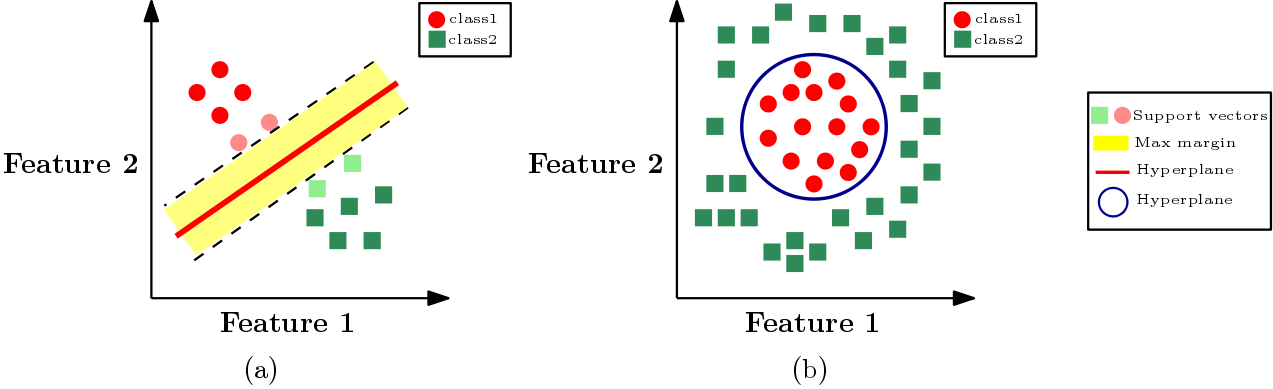

**Figure 4.1: Illustration of support vector machines principle**

**Multi-class classification:** A problem of a multi-class classification, having more than two classes, consists in:

* $\color{red}{\text{Input :}}$ A dataset of points $x_i$, each belonging to a class (defined by a specific label),
     
* $\color{red}{\text{Output :}}$ Probability of an y belonging to a certain class.

The number of classifiers used for the multi-classification problem depends on the used approach among:

* `One-vs-all (or one-vs-rest):` The number of classifiers is equal to the number of classes,
    
* `One-vs-one:` The number of classifiers is equal to $N \frac{(N -1)}{2}$, where $N$ is the number of classes.

In this exercise, the classification problem is applied on the IRIS dataset with SVM (using *Scikit-learn library*). The aim of this exercice is to apply both the multi-classification one-vs-all and one-vs-one SVM architectures and compare between them. 

In [121]:
#Import required libraries
import pandas as pd
import numpy as np
#Plotting
import matplotlib.pyplot as plt
#Customized legend for scatter
from matplotlib.colors import ListedColormap
#Load dataset, train/test data and SVM model
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
#Evaluation and metrics
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import time
#Plotting the decision functions
#pip install mlxtend
from mlxtend.plotting import plot_decision_regions
#Principal Component Analysis (PCA)
from sklearn.decomposition import PCA

### Load the IRIS dataset

To start with, the IRIS dataset is loaded and converted to a dataframe format. 

In [3]:
#Load the IRIS dataset
iris = load_iris()

#Convert the IRIS dataset to a dataframe [2]
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
print("The size of the IRIS dataset: ", iris_df.shape, "\n")
print("=================")
print("IRIS dataframe ")
print("=================")
iris_df

The size of the IRIS dataset:  (150, 5) 

IRIS dataframe 


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


One can notice that there are multiple variables (features) characterizing the IRIS dataset and a total of three flower classes (Setosa, versicolour,virginica), labeled '0', '1' and '2'. In what follows, we divide the IRIS dataset into a trainset (75% of the total data) and testset (25% of the total data) using the train_test_split function.

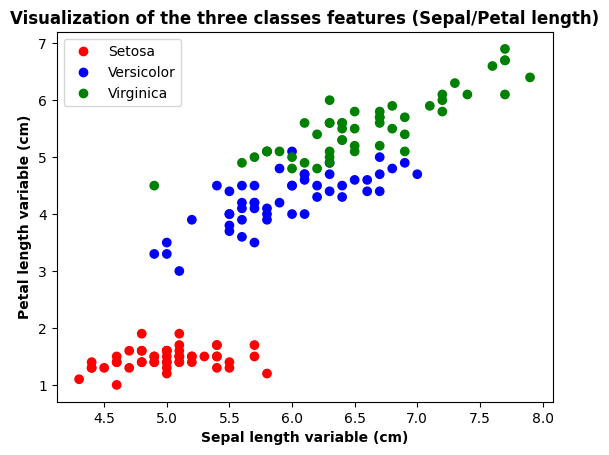

Data Information 
Data shape:  (150, 4) , Target shape:  (150,)
Train shape:  (112, 4) , Test shape:  (38, 4)


In [22]:
#Specifying the target(classes) and variables(features) of the dataset
x_iris, y_iris = iris.data,iris.target

#Plotting the data points using "y_iris" as the cluster color (3 classes)
# class_label = iris_df.loc[:,'target'].replace([0,1,2],['setosa','versicolor','virginica'])
plt.title("Visualization of the three classes features (Sepal/Petal length)",fontweight="bold")
classes = ['Setosa', 'Versicolor', 'Virginica']
colors = ListedColormap(['r','b','g'])
scatter = plt.scatter(x_iris[:,0], x_iris[:,2],c=y_iris, cmap=colors)
plt.xlabel("Sepal length variable (cm)",fontweight="bold")
plt.ylabel("Petal length variable (cm)",fontweight="bold")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

#Splitting the dataset into trainset/testset (test data represent 25% of the total dataset)
x_train,x_test,y_train,y_test=train_test_split(x_iris,y_iris,test_size=0.25)

print("=================")
print("Data Information ")
print("=================")
print("Data shape: ", x_iris.shape, ", Target shape: ", y_iris.shape)
print("Train shape: ", x_train.shape, ", Test shape: ", x_test.shape)

One can notice from the above figure, which describes the petal length/sepal length (features) of the three IRIS flower classes under study that we are facing a non-linearly separable data problem, which is characterized by the overlapping data of both the classes, represented by the blue and green dots. In a first place, we will be applying the polynomial and RBF kernel functions in building the classifiers. The performance of both models will be evaluated and compared.

**Note:** We use the *F1-score* as a classification metrics to predict the positive individuals [3](https://kobia.fr/classification-metrics-f1-score/#:~:text=Le%20F1%2Dscore%20est%20une%20m%C3%A9trique%20de%20classification%20qui%20mesure,taux%20de%20positifs%20correctement%20pr%C3%A9dits)).

### Construction/ Evaluation of an SVM Model

In [124]:
#Creation of two classifiers; with polynomial and RBF kernels
classifier_poly= SVC(kernel='poly', degree=3, C=1).fit(x_train,y_train)
classifier_rbf= SVC(kernel='rbf', gamma=0.8, C=1).fit(x_train,y_train)

#Support vectors
supp_vec_poly = classifier_poly.support_vectors_
supp_vec_rbf = classifier_rbf.support_vectors_

supp_idx_poly = classifier_poly.support_
supp_idx_rbf = classifier_rbf.support_

nb_supp_vec_poly = classifier_poly.n_support_
nb_supp_vec_rbf = classifier_rbf.n_support_
print("Support vector numbers (each class): ", "POLY: ", nb_supp_vec_poly, "RBF: ", nb_supp_vec_rbf)

#Evaluation of the model % trainset
print("Score of the SVM-POLY model (trainset): ", classifier_poly.score(x_train,y_train))
print("Score of the SVM-RBF model (trainset): ", classifier_rbf.score(x_train,y_train))

#Prediction of the iris flowers using the testset
iris_prediction_poly = classifier_poly.predict(x_test)
iris_prediction_rbf = classifier_rbf.predict(x_test)

#Calculation of the mean square error
error_pred_poly = sqrt(mean_squared_error(y_test,iris_prediction_poly))
error_pred_rbf = sqrt(mean_squared_error(y_test,iris_prediction_rbf))
print("Prediction error (testset):", "POLY: ", error_pred_poly, "RBF: ", error_pred_rbf)

#Evaluation metrics using Sklearn
print("\n==========================")
print("PLOY-Classification report ")
print("==========================")
print(classification_report(y_test,iris_prediction_poly))
print("\n==========================")
print("RBF-Classification report ")
print("==========================")
print(classification_report(y_test,iris_prediction_rbf))

#Cross validation
print("\n=======================")
print("F1-score ")
print("=======================")
cv_poly = cross_val_score(classifier_poly,x_train,y_train,scoring="accuracy")
cv_rbf = cross_val_score(classifier_rbf,x_train,y_train,scoring="accuracy")
# print("Accuracy score: ", "POLY: ", cv_poly, "RBF: ", cv_rbf)

iris_poly_f1 = f1_score(y_test, iris_prediction_poly, average='weighted')
iris_rbf_f1 = f1_score(y_test, iris_prediction_rbf, average='weighted')
print("F1 score: ", "POLY: ", iris_poly_f1, "RBF: ", iris_rbf_f1)

Support vector numbers (each class):  POLY:  [3 8 7] RBF:  [ 5 17 16]
Score of the SVM-POLY model (trainset):  0.9732142857142857
Score of the SVM-RBF model (trainset):  0.9821428571428571
Prediction error (testset): POLY:  0.0 RBF:  0.0

PLOY-Classification report 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00        14

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38


RBF-Classification report 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00        14

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        3

Using the classification report, one can notice a precision of 1 for the belonging of a test flower to a class among the three IRIS classes for both the poly and RBF kernels. Using the *score* results, one can see a slight difference between the polynomial and RBF kernels, where $score_{rbf} = 0.98 > score_{poly} = 0.97$. However, changing the SVM hyperplane parameters (polynomial degree, gamma, C) could lead in a variation of the results. 

### Plotting of the decision function of the SVM model

To be able to plot the decision regions following the apllication of the polynomial kernel, one should transform the multi-variable dataset of the IRIS dataset into a two-variable dataset. This could be done using the PCA, a linear dimensionality reduction technique by setting the n_components to 2 [4](https://stackoverflow.com/questions/52952310/plot-decision-regions-with-error-filler-values-must-be-provided-when-x-has-more).

Text(0.5, 1.0, 'RBF-Kernel SVM Decision Region Boundary')

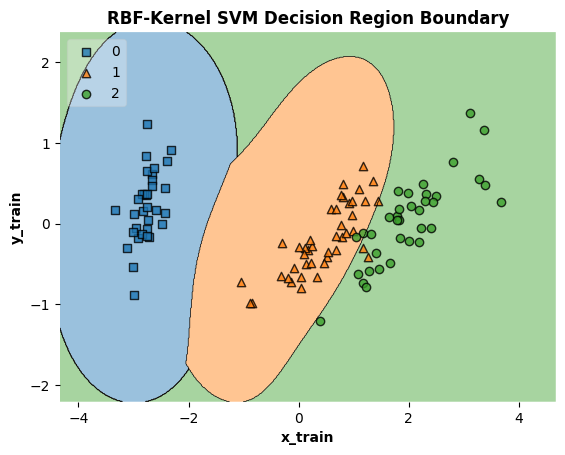

In [171]:
#Transform the multi-dimensional data to two-dimensional data using PCA
data_pca = PCA(n_components = 2)
x_train_transform = data_pca.fit_transform(x_train)

#Fitting the poly and RBF models
classifier_poly.fit(x_train_transform, y_train)
classifier_rbf.fit(x_train_transform, y_train)

#Plotting poly decision regions
# f1=plot_decision_regions(X=x_train_transform,y=y_train.astype(int),clf=classifier_poly,legend=2)
# plt.xlabel("x_train",fontweight="bold")
# plt.ylabel("y_train",fontweight="bold")
# plt.title('Poly-Kernel SVM Decision Region Boundary',fontweight="bold")

#Plotting RBF decision regions
f2=plot_decision_regions(X=x_train_transform,y=y_train.astype(int),clf=classifier_rbf,legend=2)
plt.xlabel("x_train",fontweight="bold")
plt.ylabel("y_train",fontweight="bold")
plt.title('RBF-Kernel SVM Decision Region Boundary',fontweight="bold")

Both the polynomial and the RBF kernel decision regions are plotted hereunder. The boundaries try its best, according to the given model parameters, to distinguish between the three IRIS flower classes.

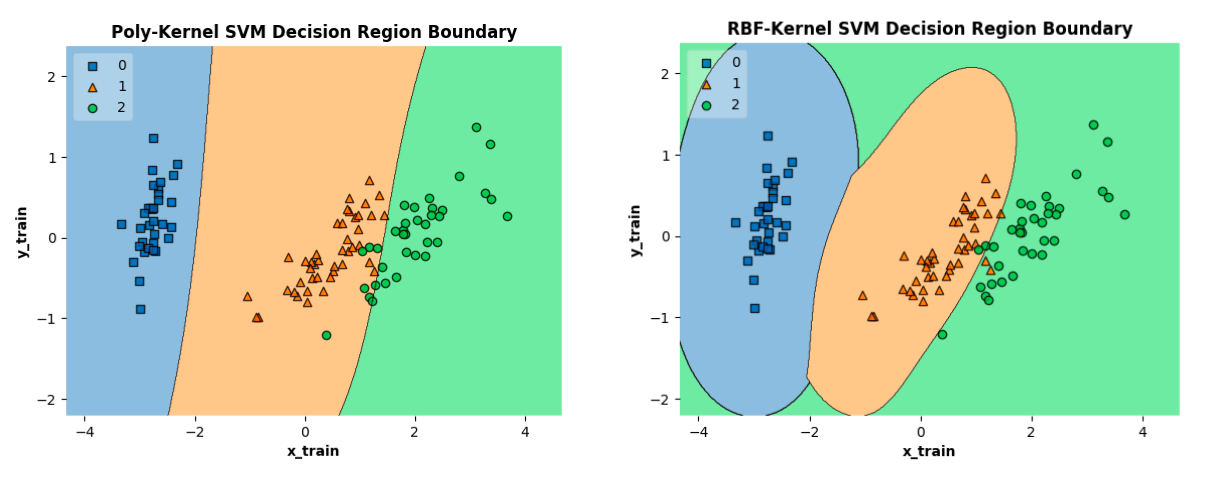

**Figure 4.2: Plotting of the decision regions using the polynomial and RBF kernels**

### Build the SVM <1 class-vs-all classes> architecture

In the <1-class-vs-all-classes> approach, also called <1-vs-the-rest> approach, all classes are trained. Thus, the number of classifiers is equal to the number of classes (n_classes). Each classifier trains data and decides among the rest of classes [5](https://bjpcjp.github.io/pdfs/scikit-0.22.1/scikit-guide-0.22.1-support-vector-machines.pdf).

For instance, figure (4.3) illustrates a 3-class classification problem, where the three classes are represented by: (red disk) class 1, (green square) class 2 and (blue cross) class 3. Thus, three classifiers are created for the three classes, such as:
* $\underline{\text{Classifier $K_1$}}$: learns to recognize the class 1 (red disk, positive) among the remaining two classes {class 2, class 3} (negative),
* $\underline{\text{Classifier $K_2$}}$: learns to recognize the class 2 (green square, positive) among the remaining two classes {class 1, class 3} (negative),
* $\underline{\text{Classifier $K_3$}}$: learns to recognize the class 3 (blue cross, positive) among the remaining two classes {class 1, class 2} (negative).

In the presented case study, we fit 3 classifiers which try to estimate the probability of the belonging of an input class y to a class among the three-classes. The elapsed time of this approach is measured, as well as its performance metrics (prediction error, precision, cross-validation score).

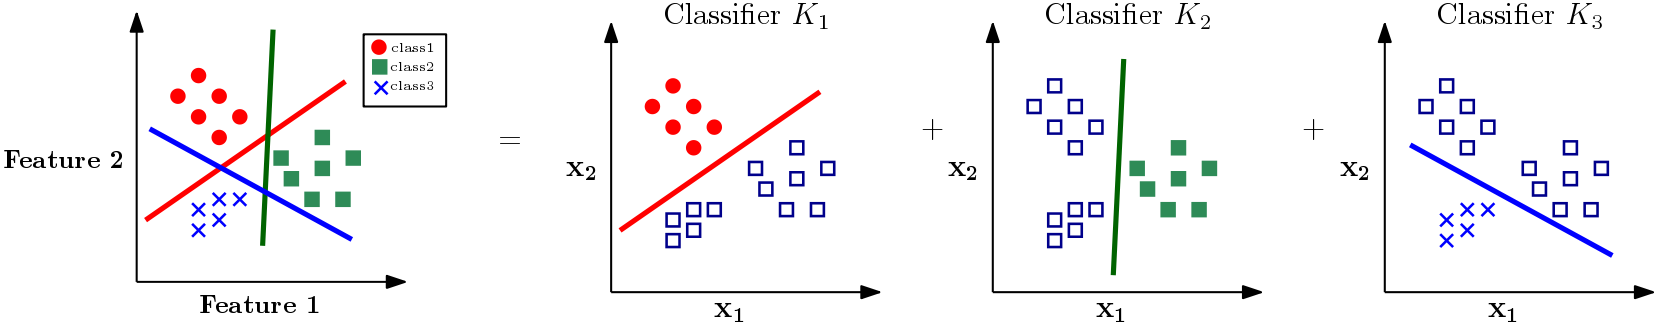

**Figure 4.3: Illustration of the 1-class-vs-all-classes approach**

In [152]:
#Multi-class classification using the OVR-SVM
t_ovr = time.time()
classifier_svm_ovr = SVC(decision_function_shape='ovr')

#Fitting of the OVR-SVM model
classifier_svm_ovr.fit(x_train,y_train)
elapsed_ovr = time.time() - t_ovr
print("Time elapsed to do the OVR-SVM approach: ", elapsed_ovr)

#Number of OVR-classifiers
dec_ovr = classifier_svm_ovr.decision_function(x_train)
print("The number of OVR-classifiers (=n_classes): ",dec_ovr.shape[1])

#Support vectors
supp_vec_ovr = classifier_svm_ovr.support_vectors_
supp_idx_ovr = classifier_svm_ovr.support_
nb_supp_vec_ovr = classifier_svm_ovr.n_support_
# print("Support vectors:\n", supp_vec_ovr)
# print("Support vector indexes:\n", supp_idx_ovr)
print("OVR Support vector numbers (each class): ", nb_supp_vec_ovr)

#Evaluation of the model % trainset
print("Score of the OVR SVM model (trainset): ", classifier_svm_ovr.score(x_train,y_train))

#Prediction of the iris flowers using the testset
iris_prediction_ovr = classifier_svm_ovr.predict(x_test)

#Calculation of the mean square error
error_pred_ovr = sqrt(mean_squared_error(y_test,iris_prediction_ovr))
print("OVR Prediction error (testset):", error_pred_ovr)

print("\n=======================")
print("Classification report ")
print("=======================")
#Evaluation metrics using Sklearn
print(classification_report(y_test,iris_prediction_ovr))

print("\n=======================")
print("Cross validation ")
print("=======================")
cv_ovr = cross_val_score(classifier_svm_ovr,x_train,y_train,scoring="accuracy")
print("cross_val_score-OVR: ", cv_ovr)

ovr_f1 = f1_score(y_test, iris_prediction_ovr, average='weighted')
print("F1 score-OVR: ", ovr_f1)

Time elapsed to do the OVR-SVM approach:  0.0012552738189697266
The number of OVR-classifiers (=n_classes):  3
OVR Support vector numbers (each class):  [ 5 26 22]
Score of the OVR SVM model (trainset):  0.9464285714285714
OVR Prediction error (testset): 0.16222142113076254

Classification report 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.88      1.00      0.93         7
           2       1.00      0.93      0.96        14

    accuracy                           0.97        38
   macro avg       0.96      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38


Cross validation 
cross_val_score-OVR:  [0.95652174 0.86956522 1.         0.95454545 1.        ]
F1 score-OVR:  0.974074074074074


From the performance evaluation of the <1 class-vs-all classes> architecture, one can notice a prediction error of 0.162 on the testset, which could be lead by the precision 0.88 in recognizing the class 1 (classification report). An F1-score indicates 0.974. The time elapsed to train the model is 0.001255sec.

### Build the SVM <1 class-vs-1-class> architecture

In the <1-class-vs-1-class> approach, only $N \frac{(N- 1)}{2}$ classifiers are constructed, where $N$ is the number of classes. Each classifier trains data and decides among two classes only [5](https://bjpcjp.github.io/pdfs/scikit-0.22.1/scikit-guide-0.22.1-support-vector-machines.pdf). 

In our case study, there are $N=3$ classes, and thus $3 \times \frac{2}{2} = 3$ classifiers. 

In this approach, the dataset is split in a way that each time the data of two opposite classes are considered, as illustrated in figure (4.4). Here, we divide the three-class problem into three classifiers, such as:

* $\underline{\text{Classifier $K_1$}}$: learns to recognize the class 1 (red disk, positive) among the class 2 (green square, negative),
* $\underline{\text{Classifier $K_2$}}$: learns to recognize the class 1 (red disk, positive) among the class 3 (blue cross, negative),
* $\underline{\text{Classifier $K_3$}}$: learns to recognize the class 2 (green square, positive) among the class 3 (blue cross, negative).

In the presented case study, we fit 3 classifiers which try to estimate the probability of the belonging of y to a class label. The elapsed time of this approach is measured, as well as its performance metrics (prediction error, precision, cross-validation score).

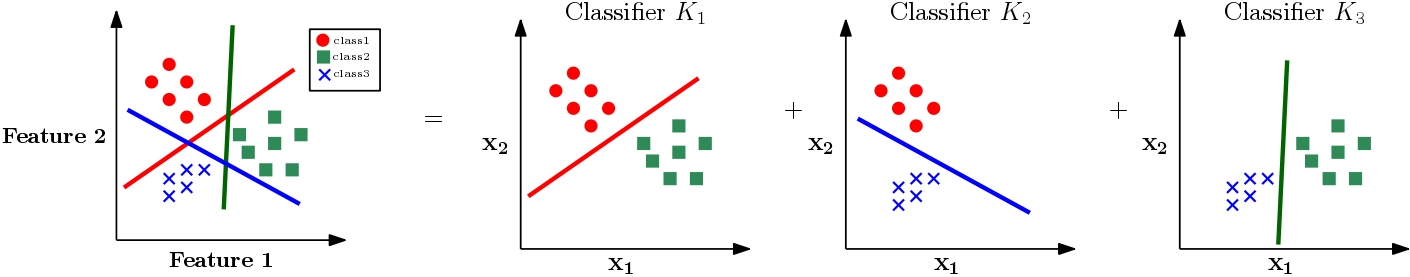

**Figure 4.4: Illustration of the 1-class-vs-1-class approach**

In [162]:
#Multi-class classification using the OVO-SVM
t_ovo = time.time()
classifier_svm_ovo = SVC(decision_function_shape='ovo')

#Fitting of the OVO-SVM model
classifier_svm_ovo.fit(x_train,y_train)
elapsed_ovo = time.time() - t_ovo
print("Time elapsed to do the OVO-SVM approach: ", elapsed_ovo)

#Number of OVO-classifiers
dec_ovo = classifier_svm_ovo.decision_function(x_train)
print("The number of OVO-classifiers (=0.5*3*2): ",dec_ovo.shape[1])

#Support vectors
supp_vec_ovo = classifier_svm_ovo.support_vectors_
supp_idx_ovo = classifier_svm_ovo.support_
nb_supp_vec_ovo = classifier_svm_ovo.n_support_
# print("Support vectors:\n", supp_vec_ovo)
# print("Support vector indexes:\n", supp_idx_ovo)
print("OVO Support vector numbers (each class): ", nb_supp_vec_ovo)

#Evaluation of the model % trainset
print("Score of the OVO SVM model (trainset): ", classifier_svm_ovo.score(x_train,y_train))

#Prediction of the iris flowers using the testset
iris_prediction_ovo = classifier_svm_ovo.predict(x_test)

#Calculation of the mean square error
error_pred_ovo = sqrt(mean_squared_error(y_test,iris_prediction_ovo))
print("OVO Prediction error (testset):", error_pred_ovo)

print("\n=======================")
print("Classification report ")
print("=======================")
#Evaluation metrics using Sklearn
print(classification_report(y_test,iris_prediction_ovo))

print("\n=======================")
print("Cross validation ")
print("=======================")
cv_ovo = cross_val_score(classifier_svm_ovo,x_train,y_train,scoring="accuracy")
print("cross_val_score-OVO: ", cv_ovo)

ovo_f1 = f1_score(y_test, iris_prediction_ovo, average='weighted')
print("F1 score-OVO: ", ovo_f1)

Time elapsed to do the OVO-SVM approach:  0.0007417201995849609
The number of OVO-classifiers (=0.5*3*2):  3
OVO Support vector numbers (each class):  [ 5 26 22]
Score of the OVO SVM model (trainset):  0.9464285714285714
OVO Prediction error (testset): 0.16222142113076254

Classification report 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.88      1.00      0.93         7
           2       1.00      0.93      0.96        14

    accuracy                           0.97        38
   macro avg       0.96      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38


Cross validation 
cross_val_score-OVO:  [0.95652174 0.86956522 1.         0.95454545 1.        ]
F1 score-OVO:  0.974074074074074


From the performance evaluation of the <1 class-vs-one class> architecture, one can notice a prediction error of 0.162 on the testset, which could be lead by the precision 0.88 in recognizing the class 1 (classification report). An F1-score indicates 0.974. The time elapsed to train the model is 0.000741sec.

### Multiclass classification plotting

Text(0.5, 1.0, 'one-vs-all SVM Decision Region Boundary')

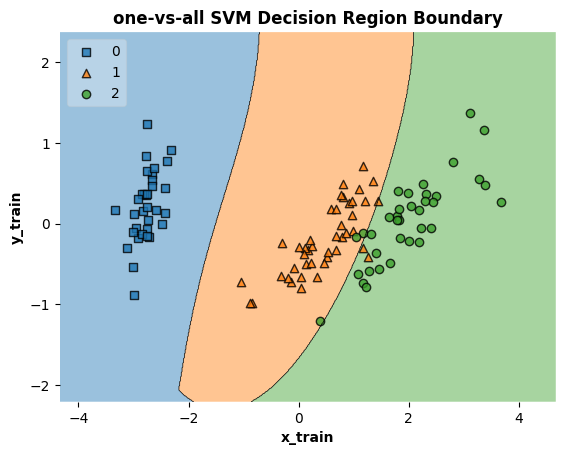

In [173]:
#Training the classifiers using 2 features
classifier_svm_ovr.fit(x_train_transform, y_train)
# classifier_svm_ovo.fit(x_train_transform, y_train)

#Plotting the decision regions
plot_decision_regions(X=x_train_transform,y=y_train.astype(int),clf=classifier_svm_ovr,legend=2)
# plot_decision_regions(X=x_train_transform,y=y_train.astype(int),clf=classifier_svm_ovo,legend=2)

plt.xlabel("x_train",fontweight="bold")
plt.ylabel("y_train",fontweight="bold")
plt.title('one-vs-all SVM Decision Region Boundary',fontweight="bold")

### Conclusions

In this exercise, the multi-classification in done using two architectures described above. The results comparison between both approaches yields the following:
* `In one-vs-all approach:` The same data is given to each of the classifier (equal to the number of classes), 
* `In one-vs-one approach:` The training data of two classes is given in order to separate between them. This speeds the multi-classification problem resolution. However, since it requires an important number of classifiers, this approach is penalized. 
* `Application to the IRIS dataset:` In this case study, the number of classifiers is equal to 3 for both the used architectures (so it has no effect on the results). Since the SVM scales poorly with the size of the training set, and for the same number of classifiers, the one-vs-one approach uses less training set. The evaluation of the elapsed time while training both models using the one-vs-one and one-vs-all architectures highlights the finding that we gain a speed up of $16.8 \%$ while using the one-vs-one SVM architecture.

#### References:
[1] https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/

[2] https://stackoverflow.com/questions/38105539/how-to-convert-a-scikit-learn-dataset-to-a-pandas-dataset

[3] https://kobia.fr/classification-metrics-f1-score/#:~:text=Le%20F1%2Dscore%20est%20une%20m%C3%A9trique%20de%20classification%20qui%20mesure,taux%20de%20positifs%20correctement%20pr%C3%A9dits).

[4] https://stackoverflow.com/questions/52952310/plot-decision-regions-with-error-filler-values-must-be-provided-when-x-has-more

[5] https://bjpcjp.github.io/pdfs/scikit-0.22.1/scikit-guide-0.22.1-support-vector-machines.pdf

## Exercise 5:  <a id='ex5'></a>

This is a good reference to follow [Support_Vector_Machine_Ensemble_with_Bagging](https://www.researchgate.net/publication/220785878_Support_Vector_Machine_Ensemble_with_Bagging). Unfortunately, I had no time :( .


## Exercise 6 :  <a id='ex6'></a>

The **Ensemble methods** consist in generating different functions from the same training data. A basic method is usually selected to generate these functions. 

There is two main approaches in Ensemble methods: (1) Bagging and (2) Boosting. Only Bagging is considered in this exercise. This method consists in the generation of the different functions in parallel and in an indepedent manner The results are then averaged to get an optimal final result. So the *Bagging* rely on the "Wisdom of crowds" phenomenon. In order to get different results from the same training data, the data is re-sampled by *Bootstrap*.

### Why Ensemble methods for unsupervised learning are tricky to use ?

The different generated functions may lead to multiple results (multiple classifiers for instance) without knowing the reliability of each result, and with no labeled data to assess it. The different functions may evan lead to conflicting results, which is particularly encountered in the case of dependent classifiers [1](https://arxiv.org/pdf/1510.05830.pdf).

Another challenge is the formulation of a similarity matrix from all generated results.

### Implementation of the proposed method

In this exercice, **all the algrithms were implemented from scratch**. The built-in functions of sklearn were not used. This allowed a deep understanding of the different steps and difficulties.

In the following section, we will follow step by step the proposed method in the assignment. First, functions will be defined for each algorithm. Next, a pipeline of the different algorithm will be created. Finally, a demonstration will be carried out on the datasets defined in Lab3, sec7, and the results will be analysed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

### Definition of the cloud points plotting function

First of all, we will be needing to plot the cloud points several times, which will be colored with their clusters. So, let's define a function of this purpose.

In [2]:
#Functions definition
def plot_pts_clusters(pts_clusters,ax,title):
    """
    Plot points cloud colored with label

    Parameters
    ----------
    pts_clusters : Tuple(Points_cloud, Labels)
    ax : Object
        The subplot on which the data will be scattered
    title : String
        Title of the subplot

    Returns
    -------
    None.

    """
    points, labels = pts_clusters
    labels_names = {}
    clusters = []
    icluster = -1
    for idx, label in enumerate(labels):
        if label not in labels_names.keys():
            icluster +=1
            labels_names[label] = icluster
            clusters.append([points[idx]])
        else:
            clusters[labels_names[label]].append(points[idx])
    for i, cluster in enumerate(clusters):
        ax.scatter([pt[0] for pt in cluster], [pt[1] for pt in cluster])
    ax.set_title(title)

### Definition of the K-means clustering algorithm

The proposed clustering algorithm base classifier for bagging is the well known *k-means*. The "naive" version of k-means is implemented here. Here is a pseudocode of the algorithm:
1. Randomly select $k$ samples from the dataset as *means*.
2. Devide the dataset into $k$ clusters according to the distance of the samples to the $k$ means.
3. Update the mean point of each cluster.
4. Go back to step (2). The algorithm stops if the clusters do not change between two successive iterations.

The *k_means* function returns a list of labels.

In [3]:
def compute_dist(pt1,pt2):
    """
    Compute the square euclidean distance between pt1 and pt2.
    Implemented for a generic dimension

    Parameters
    ----------
    pt1 : Array like
        The coordinate of the fisrt point
    pt2 : Array like
        The coordiantes of the second point

    Returns
    -------
    dist: float
        Squatred  Euclidian distance between pt1 and pt2

    """    
    return sum([(pt1[i]-pt2[i])**2 for i in range(len(pt1))])

# Mean-point of a cluster function
def compute_mean_cluster(cluster):
    """
    Returns the coordinates of the mean point of the given cluster

    Parameters
    ----------
    points : Array_like of size n, each point of size dim
        points data of the cluster

    Returns
    -------
    filter_matrix : List of size dim
        Mean poinnt coordinates of data points in cluster
        
    """    
    dim = len(cluster[0])
    N = len(cluster)
    return [sum([pt[i] for pt in cluster])/N for i in range(dim)]

# K-means algorithm
def k_means(points,k):
    """
    k-means clustering algorithm.

    Parameters
    ----------
    points : Array_like of size n
        points cloud
    k : int
        required number of clusters

    Returns
    -------
    filter_matrix : array_like of shape (n,n)
        Symmetric matrix. Each element in position (i,j) is equal to 1 if point j is among the k nearest neighbor
        of pointj OR the inverse, and 0 otherwise 

    """    
    N = len(points) # size of the input points
    
    # Initialize the the k means randomly between the input points
    means_idx = np.random.uniform(0,N-1,k)
    means = [points[int(idx)] for idx in means_idx]

    labels = [0 for i in range(N)]
    converged = False
    while not converged:
        converged = True
        for pt_idx, pt in enumerate(points):
            min_dist = float('+inf')
            for mean_idx, mean in enumerate(means):
                dist = compute_dist(pt,mean)
                if dist < min_dist:
                    min_dist, best_idx = dist, mean_idx
            if labels[pt_idx] != best_idx:
                converged = False
                labels[pt_idx] = best_idx
                
        # Recompute means
        for mean_idx in range(k):
            cluster = [pt for idx, pt in enumerate(points) if labels[idx] == mean_idx]
            if len(cluster) > 0:
                means[mean_idx] = compute_mean_cluster(cluster)
    return labels

### Definition of the Spectral graph clustering function

**Spectral graph clustering** is also an important algorithm in the proposed bagging method. The implemented version is the unormalized spectral clustering taken from [2]. For a given similarity matrix $A$, a diagonal degree matrix $D$ will be computed as $d_{i,i} = \sum_j a_{i,j}$. Then, we compute the Laplacian matrix $L = D - A$. We compute the eigenvalues and eigenvectors of $L$ and we select only the $q$ eigenvectors corresponding to the smallest "q" eigenvalues, with $q >= k$. Theoritically we need to keep only $k$ eigenvectors, but we may need more in practice. The matrix $U$ is formed by the selected eigenvectors as columns. Finally, we cluster the rows of $U$ using k-means. The labels of a row $i$ will correspond to the label of a points $i$. Note that the number of zero eigenvalues theoritically equals the number of sperate clusters identified in the graph [2](https://arxiv.org/pdf/1510.05830.pdf) [3](https://people.csail.mit.edu/dsontag/courses/ml14/notes/Luxburg07_tutorial_spectral_clustering.pdf).

In [6]:
def unormalized_spectral_clustering(simularity_matrix,k,q):
    """
    Spectral graph clustering algorithm.
    Based on [2]: 
    https://people.csail.mit.edu/dsontag/courses/ml14/notes/Luxburg07_tutorial_spectral_clustering.pdf

    Parameters
    ----------
    similarity_matrix : array_like of sahpe (n,n) with n the number of the points to cluster
        Pre-computed similarity matrix
    k : int
        number of desired clusters
    q : int
        number of eigenvectors to consider for the sclustering

    Returns
    -------
    labels : array_like of size n
        labels of the resulting clusters

    """
    N = len(simularity_matrix)
    
    # Compute the degree matrix
    D = np.diag([np.sum(simularity_matrix[i]) for i in range(N)])
    
    # Compute Laplacian matrix
    L = D - simularity_matrix
    
    # Compute the eigenvalues and eigenvectoors of L
    w, v = np.linalg.eig(L)
    
    # Select only eigenvectors corresponding to the smallest q eigenvalues
    sorted_eigval_idx = sorted(range(len(w)), key = lambda i: w[i])
    U = np.zeros((N,q))
    for i in range(q):
        U[:,i] = v[:,sorted_eigval_idx[i]]
        # print("eigenvalue ",i,w[sorted_eigval_idx[i]])
    
    points = [list(U[i]) for i in range(N)]
    
    # Use k-means for the final clustering
    labels = k_means(points,k)
    
    return labels

We presented above the base algorithm used for bagging (k-means) and the graph clustering algorithm (specral clustering), which will return the results. However, between these two steps, we need to formulate a simularity matrix. Basicaly, we count how many times a point $i$ and a point $j$ shared the same cluster. We normalize these counts between $0$ and $1$, with one meaning that: the two points share always the same cluster.

### Definition of the k-Nearest-Neighbor filter function

We may also need to apply an additional filter to the similarity matrix before passing it to the spectral clustrering. We chose to use *k-Nearest-Neighbor* filter, which is defined as the following (more comments about this filter in Exercice 8):

In [7]:
def compute_dist_matrix(points):
    """
    Return the distance (squared euclidean distance) between each point with and all other point

    Parameters
    ----------
    points : Array_like of size n
        points cloud

    Returns
    -------
    dist_matrix : array like of shape (n,n)
        each element in position (i,j) represents the squared distance between point i and point j

    """    
    N = len(points)
    dist_matrix = np.zeros((N,N))
    for i in range(N):
        for j in range(i):
            dist = compute_dist(points[i], points[j])
            dist_matrix[i,j], dist_matrix[j,i] = dist, dist
    return dist_matrix

# KNN-filter
def kNN_filter(points,k):
    """
    k-Nearest-Neighbor filter applied on the data points.

    Parameters
    ----------
    points : Array_like of size n
        points cloud
    k : int
        number nearest neighbors to search around each point

    Returns
    -------
    filter_matrix : array_like of shape (n,n)
        Symmetric matrix. Each element in position (i,j) is equal to 1 if point j is among the k 
        nearest neighbor of point j OR the inverse, and 0 otherwise 

    """
    N = len(points)
    kNN_matrix = np.zeros((N,N)) # Temporary matrix to store the kNN of each point
    
    dist_matrix = compute_dist_matrix(points) # Compute the distance matrix
    
    # The returned matrix, of course the diagonal elements are equal to 1
    filter_matrix = np.diag([1 for i in range(N)]) 
    
    # Search for k-nearest neighbor by sorting the distance with all other points
    for i in range(N):
        sorted_neighbors = sorted(range(N), key = lambda l : dist_matrix[i,l])
        for j in range(k+1): # we add 1 to acount for the point it self (distance 0)
            kNN_matrix[i,sorted_neighbors[j]] = 1
    
    # Fill the returned matrix in symmetric way
    for i in range(N):
        for j in range(i):
            if (kNN_matrix[i,j] == 1) or (kNN_matrix[j,i] == 1):
                filter_matrix[i,j], filter_matrix[j,i] = 1, 1  
    
    return filter_matrix

### The Main programm

In [9]:
                                    ### Main programm ###

########################################################################################################
#####Generation of the datasets (from Lab3, Seq7). They are stoored in a dict#####
########################################################################################################
n_samples = 500

noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# Blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

# Putting all the datasets in a dict
testdatas = {}
testdatas["Noisy Circles"] = {"data":noisy_circles, "n_clusters":2}
testdatas["Noisy Moons"] = {"data":noisy_moons, "n_clusters":2}
testdatas["Blobs"] = {"data":blobs, "n_clusters":3}
testdatas["Anisotropic Data"] = {"data":aniso, "n_clusters":3}
testdatas["Varied Gaussians"] = {"data":varied, "n_clusters":3}

### Clustering Algorithm with Bagging (proposed version in the assignement)

We put together all the different steps described previously and we loop on the datasets. All the results are summerized in subplots. For each dataset (organized in columns in the subplots), we display the original clusters, then the result of single application of *k-means* is displayed. We display also the result of application of the spectral clustering, with a similarity matrix being prepared with only the k-Nearest-Neighbor filter. This will allow to assess the real benefit of bagging compared to the different algorithms in the pipeline.

**NB:** Generally we need to randomize the dataset in each iteration of bagging. This is not necessary in this method as k-means algorithm is already randomly initialized. We run some tests with randomized datasets without any noticible influence on the results.

Finally, the results of bagging are displayed, with and without the application of the k-Nearest-Neighbor filter in the similarity matrix.

/tmp/ipykernel_8710/2756173096.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  U[:,i] = v[:,sorted_eigval_idx[i]]


end for dataset Noisy Circles
end for dataset Noisy Moons
end for dataset Blobs
end for dataset Anisotropic Data
end for dataset Varied Gaussians


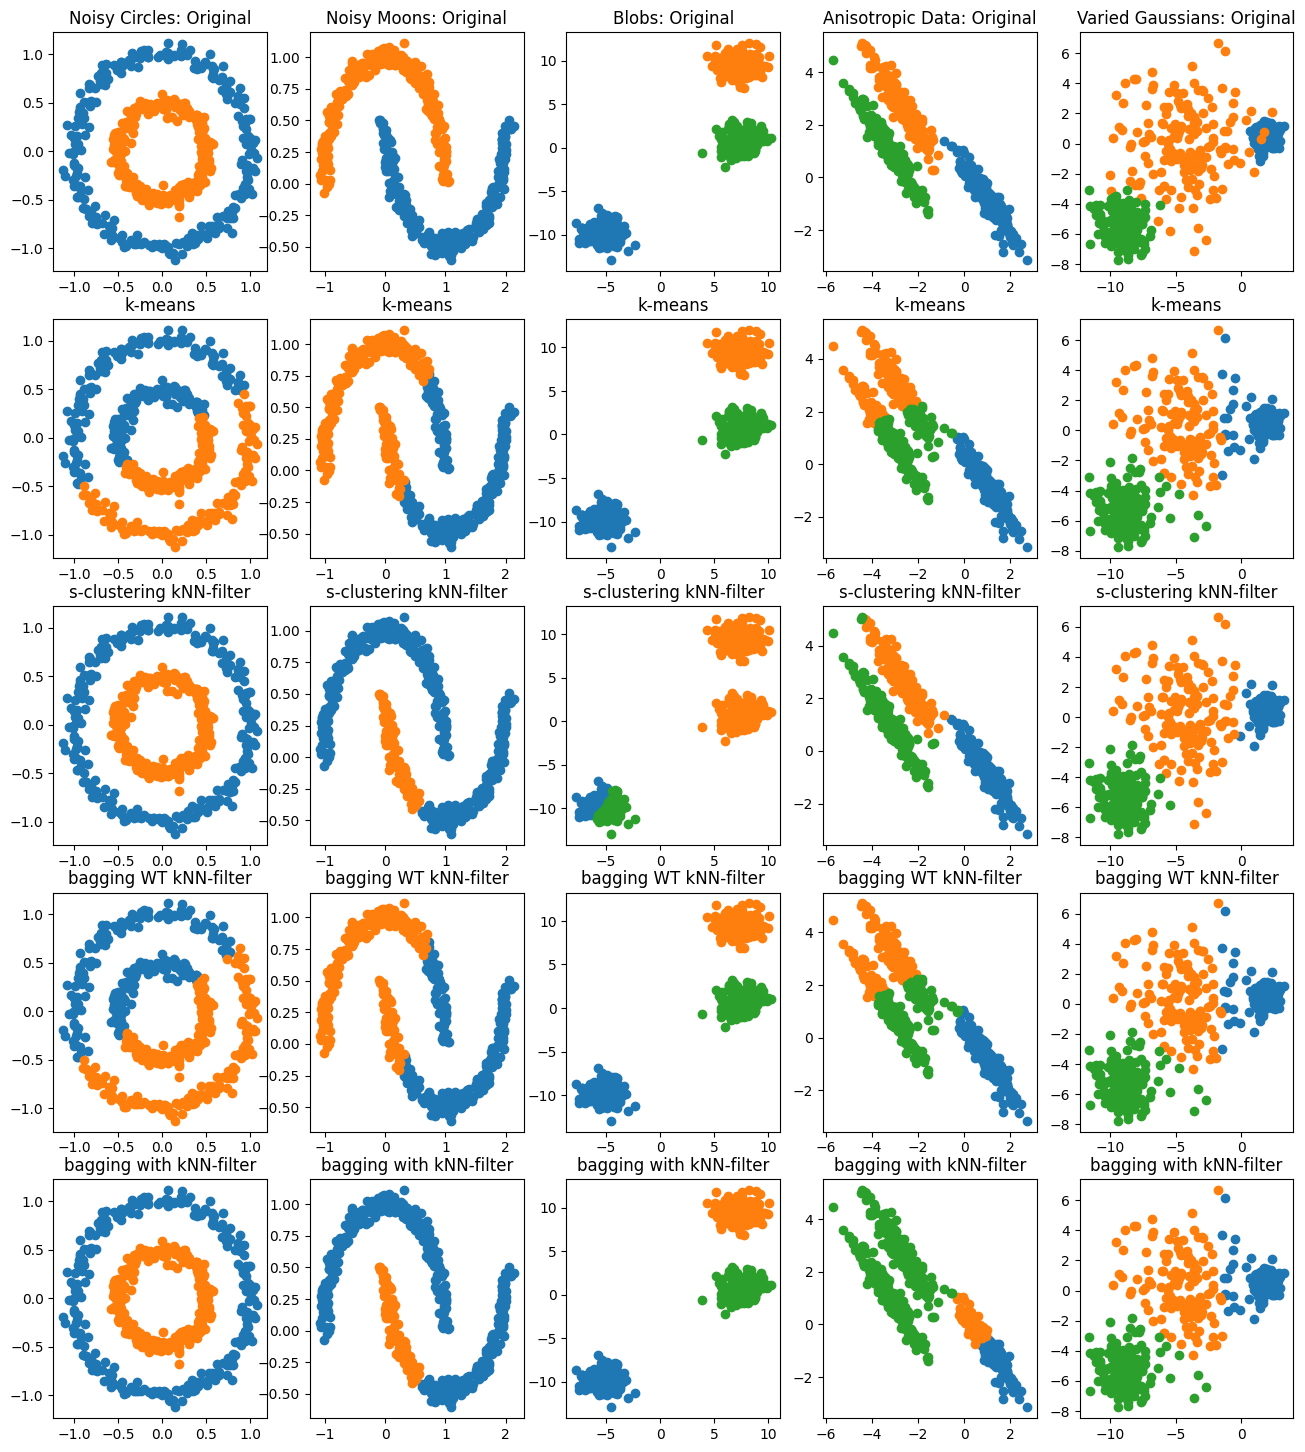

In [12]:
########################################################################################################
############################## Clustering Algorithm with bagging ###################################
########################################################################################################
fig, axs = plt.subplots(nrows = 5, ncols = len(testdatas), figsize=(16,18))

nbr_iter = 50 # Number of bagging iterations
n_kNN = 5
for idx, (key, data) in enumerate(testdatas.items()):
    k = data["n_clusters"]
    pts_clusters = data["data"]
    points, true_labes = pts_clusters
    N = len(points)
    
    # Display the dataset with the true labels
    plot_pts_clusters(pts_clusters,axs[0,idx],key+": Original")
    
    # Display the result of the naive k-means algorithm
    plot_pts_clusters((points,k_means(points,k)),axs[1,idx],"k-means")
    
    # Apply kNN filter and pass it to spectral clustring
    filter_matrix = kNN_filter(points,n_kNN)
    labels = unormalized_spectral_clustering(filter_matrix,k,k)
    plot_pts_clusters((points,labels),axs[2,idx],"s-clustering kNN-filter")
    
    # Start bagging algorithm
    all_labels = [] # list of the labels of all the iterations
    for iteration in range(nbr_iter):
        """ 
        Randomize the points before calling k-means, dosent't have any influence on the results as the 
            initialization of k-means is already random 
        """
        # Randomized_points, indices_dict = randomize_pts_clusters(points)
        # labels = k_means(randomized_points,k)
        # all_labels.append([labels[indices_dict[i]] for i in range(N)])
        all_labels.append(k_means(points,k))
        #print(iteration+1,"/",nbr_iter)

    # Compute the number of  times a point i whas in the same cluster as point j
    count_matrix = np.diag([float(nbr_iter) for i in range(N)])
    for i in range(N):
        for iteration in range(nbr_iter):
            ilabel = all_labels[iteration][i]
            for j in range(i):
                if all_labels[iteration][j] == ilabel:
                    count_matrix[i][j] += 1
                    count_matrix[j][i] += 1
    
    # Normalize between 0 and 1
    for i in range(N):
        for j in range(N):
            count_matrix[i,j] /= nbr_iter
    
    # Spectral clustering of count_matrix without any filtering
    labels = unormalized_spectral_clustering(count_matrix,k,k)
    plot_pts_clusters((points,labels),axs[3,idx],"bagging WT kNN-filter")
    
    # Spectral clustering of count_matrix filtered with kNN
    similarity_matrix = np.multiply(count_matrix, filter_matrix)
    labels = unormalized_spectral_clustering(similarity_matrix,k,k)
    plot_pts_clusters((points,labels),axs[4,idx],"bagging with kNN-filter")
    print("end for dataset "+key)
########################################################################################################
######################### Clustering Algorithm with bagging 2sd version ##############################
#########################################################################################################
fig, axs = plt.subplots(nrows = 1, ncols = len(testdatas), figsize=(14,4))

for idx, (key, data) in enumerate(testdatas.items()):
    k = data["n_clusters"]
    pts_clusters = data["data"]
    points, true_labes = pts_clusters
    N = len(points)
    
    # Start bagging algorithm
    all_labels = [] # list of the labels of all the iterations
    
    for iteration in range(nbr_iter):
        all_labels.append(k_means(points,k*10))
        #print(iteration+1,"/",nbr_iter)
    
    # Compute the number of  times a point i was in the same cluster as point j
    count_matrix = np.diag([float(nbr_iter) for i in range(N)])
    for i in range(N):
        for iteration in range(nbr_iter):
            ilabel = all_labels[iteration][i]
            for j in range(i):
                if all_labels[iteration][j] == ilabel:
                    count_matrix[i][j] += 1
                    count_matrix[j][i] += 1
    
    # Normalize between 0 and 1
    for i in range(N):
        for j in range(N):
            count_matrix[i,j] /= nbr_iter
    
    # Spectral clustering of count_matrix without any filtering
    labels = unormalized_spectral_clustering(count_matrix,k,k)
    plot_pts_clusters((points,labels),axs[idx],key)
    print("end for dataset "+key)

### Results analysis and conclusions:



**NB:** The k-means is randomly initialized, the execution is different each time the above code is run. The final result is not very robust, and may change between different runs. This will not change the interpretation given in the following. The main parameters that influence the final results of baggin is number of nearest neighbor "n_kNN" to compute the filter. It was fixed to 25 (5% of samples number) for all the datasets, we may need different n_kNN for the diffrent datasets.
 
The naive k-means behaves as expected, the noisy circle, noisy moons and isotropic datasets are not well predicted. This is normal as the points labels do not follow at all a pattern based on the distance between points. Only the results for the blobs, and the gaussians with different standart deviation are acceptable.

The direct application of kNN filter and spectral clustring (third row) gives already relatively good results! The noisy circles and moons are well prediceted as well as the blobs. The anisotropic dataset still more difficult to predict.

About bagging without application of kNN filter on the similarity matrix (fourth row): the results are not better than naive k-means.

Bagging with application of kNN filter on the similarity matrix gives results similar to the ones obtained by the direct application of spectral clustrering.

To conclude, for the used parameters, bagging has not real influence on the results, and kNN filter seems control everything.

But we didn't gave up, we tried to get acceptable results with bagging, and without application on the kNN filter !

#### Clustering Algorithm with Bagging (other version)

The idea was found in forum discussing using Ensemble method for clustering (reference lost). It consists of ruanning the naive k-means with $k$ bigger than wanted number of cluster (10 times higher on the following test). This will naturally gives some filtering to the similarity matrix.

/tmp/ipykernel_544685/2756173096.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  U[:,i] = v[:,sorted_eigval_idx[i]]


end for dataset Noisy Circles
end for dataset Noisy Moons
end for dataset Blobs
end for dataset Anisotropic Data
end for dataset Varied Gaussians


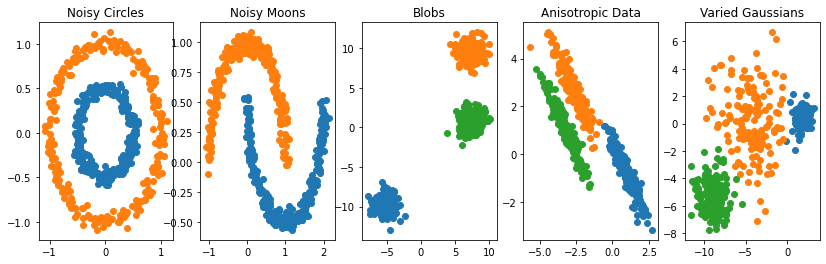

In [ ]:
########################################################################################################
######################### Clustering Algorithm with bagging 2sd version ##############################
#########################################################################################################
fig, axs = plt.subplots(nrows = 1, ncols = len(testdatas), figsize=(14,4))

for idx, (key, data) in enumerate(testdatas.items()):
    k = data["n_clusters"]
    pts_clusters = data["data"]
    points, true_labes = pts_clusters
    N = len(points)
    
    # Start bagging algorithm
    all_labels = [] # list of the labels of all the iterations
    
    for iteration in range(nbr_iter):
        all_labels.append(k_means(points,k*10))
        #print(iteration+1,"/",nbr_iter)
    
    # Compute the number of  times a point i was in the same cluster as point j
    count_matrix = np.diag([float(nbr_iter) for i in range(N)])
    for i in range(N):
        for iteration in range(nbr_iter):
            ilabel = all_labels[iteration][i]
            for j in range(i):
                if all_labels[iteration][j] == ilabel:
                    count_matrix[i][j] += 1
                    count_matrix[j][i] += 1
    
    # Normalize between 0 and 1
    for i in range(N):
        for j in range(N):
            count_matrix[i,j] /= nbr_iter
    
    # Spectral clustering of count_matrix without any filtering
    labels = unormalized_spectral_clustering(count_matrix,k,k)
    plot_pts_clusters((points,labels),axs[idx],key)
    print("end for dataset "+key)

#### References:

[1] https://arxiv.org/pdf/1510.05830.pdf

[2] https://people.csail.mit.edu/dsontag/courses/ml14/notes/Luxburg07_tutorial_spectral_clustering.pdf

## Exercice 7:   <a id='ex7'></a>

In this exercise, we generate two gaussians defined by a set of parameters. The objective is to assess the influence of these parameters on the accuracy of K-NeighborsClassifier.

$\mathbf{\underline{\text{List of parameters:}}}$ 

* The size of the dataset $n \in \{50, 100, 200\}$,
* The overlap of the classes $\delta \in\{\sigma, 2\sigma, 3\sigma, 4\sigma\}$ (distance between classes),
* The dimensionality $dim\in\{1,2,3,...\,,10, 20, 30,...\,100\}$ of the data.

The following function assess the score of the classifier for a given set of parameters. It is computed for defined range of $k$ to be used for the KNeighborsClassifier. Two scors are computed:
* With classical train/test splitting
* 10 folded Cross Validation

The assessment is performed $10$ times and the results are averaged.

In [1]:
# Import required libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
# Define a constant sigma value
sigma =2

In [11]:
def compute_scores(size,dim,overlap,k_range,n_runs=10,cv=10):
    """
    Train KNeighborsClassifier then compute the accuracy.

    Parameters
    ----------
    size : int
        Number of samples in each gaussian.
    dim : int
        size of the features dimension
    overlap : float
        Distance between the centers of the two gaussians.
    k_range : array_like
        Range ok tested k for KNeighborsClassifier.
    n_runs : int, Optional
        Number of runs to compute scores. The default is 10.
    cv : int, Optional
        Number of folds to compute CV score. The default is 10.

    Returns
    -------
    Accuracy : Array of the same size as k_range
        
    AccuracyCV : Array of the same size as k_range
    
    """
    Accuracy, AccuracyCV = [], []
    
    # Define the split
    split = int(size*2*0.8)
    
    # Generate the datasets for the n_runs
    centers = [[0 for _ in range(dim)],[0 for _ in range(dim-1)]+[overlap]]
    datas = [datasets.make_blobs(n_samples=[size, size], centers=centers, n_features=dim, cluster_std=sigma, random_state=100) for _ in range(n_runs)]
    
    for  k in k_range:
        accuracy = 0
        accuracyCV = 0
        for (X,y) in datas:
            
            # Train KNeighborsClassifier
            kNN = KNeighborsClassifier(n_neighbors=k).fit(X[:split],y[:split])
            
            # Compute the accuracy
            accuracy += kNN.score(X[split:],y[split:])
           
            # Compute CV accuracy
            cv_errors = cross_val_score(KNeighborsClassifier(n_neighbors=k), X, y, scoring="accuracy", cv=cv)
            accuracyCV += np.mean([cv_errors[i] for i in range(cv)])
        Accuracy.append(accuracy/float(n_runs))
        AccuracyCV.append(accuracyCV/float(n_runs))
            
    return Accuracy, AccuracyCV

#### Definition of the parameters ranges

In [3]:
sizes = [50, 100, 200]
dims = [i for i in range(1,11)]+[i*10 for i in range(2,11)]
sigma = 2
overlaps = [i*sigma for i in range(1,5)]
k_range = [i*10 for i in range(1,6)]
n_runs = 10

In what follows, we adopt the following statements:
* The ``classical train/split curves`` are represented by continued lines,
* The ``cross-validation curves`` are represented by dashed lines.

#### Variation of accuracy with respect to size $n$ ($k$ shown as a parameter (legend), $dim = 2$, overlap $ \delta= sigma$)

Text(0.5, 1.0, 'Variation of the accuracy with respect to size n')

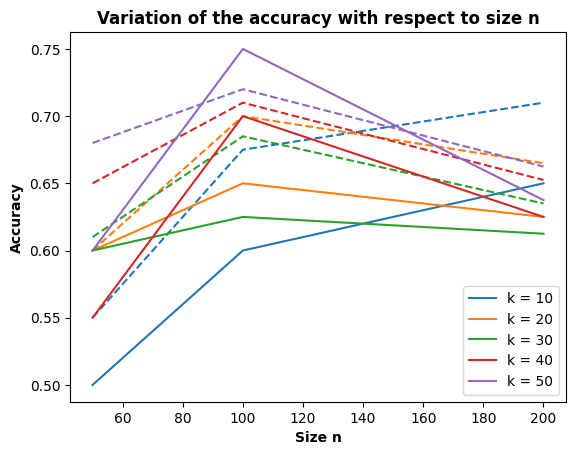

In [6]:
Accuracy = []
AccuracyCV = []
dim = 2
overlap = sigma
for size in sizes:
    accuracy, accuracyCV = compute_scores(size,dim,overlap,k_range)
    Accuracy.append(accuracy)
    AccuracyCV.append(accuracyCV)
# Plotting
plt.figure()
for k_idx, k in enumerate(k_range):
    plt.plot(sizes, [Accuracy[i][k_idx] for i in range(len(sizes))], '-', c='C'+str(k_idx), label='k = '+str(k))
    plt.plot(sizes, [AccuracyCV[i][k_idx] for i in range(len(sizes))], '--', c='C'+str(k_idx))
plt.legend()
plt.xlabel("Size n",fontweight="bold")
plt.ylabel("Accuracy",fontweight="bold")
plt.title("Variation of the accuracy with respect to size n",fontweight="bold")

The computed accuracy varies between $0.5$ and $0.75$. The accuracy computed with CV is generally higher, except for $k=50$. We can notice a relationship between the size of the samples and and the used $k$ parameter. The accuracy improves with increasing the size for small values of $k$. For $k=10$ and $k=30$, the accuracy almost doesn't depend on the size. For higher numbers of $k$, it seems that there is an optimal size for which the accuracy peaks.

#### Variation of accuracy with respect to the overlap $\delta$ ($k$ shown as a parameter, $dim = 2$, size $n= 50$)

Text(0.5, 1.0, 'Variation of the accuracy with respect to the overlap delta')

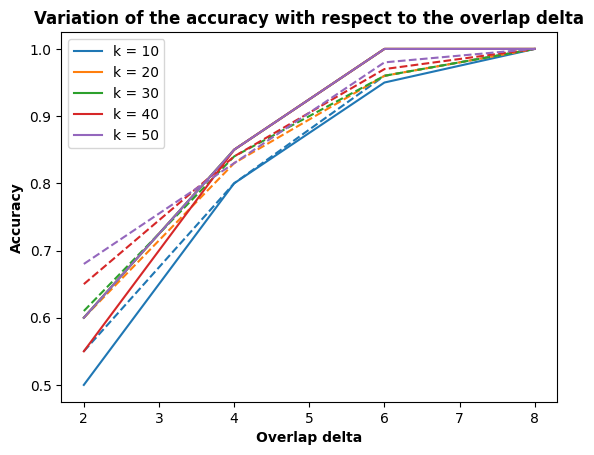

In [8]:
Accuracy = []
AccuracyCV = []
dim = 2
size = 50
for overlap in overlaps:
    accuracy, accuracyCV = compute_scores(size,dim,overlap,k_range)
    Accuracy.append(accuracy)
    AccuracyCV.append(accuracyCV)
# Plotting
plt.figure()
for k_idx, k in enumerate(k_range):
    plt.plot(overlaps, [Accuracy[i][k_idx] for i in range(len(overlaps))], '-', c='C'+str(k_idx), label='k = '+str(k))
    plt.plot(overlaps, [AccuracyCV[i][k_idx] for i in range(len(overlaps))], '--', c='C'+str(k_idx))
plt.legend()
plt.xlabel("Overlap delta",fontweight="bold")
plt.ylabel("Accuracy",fontweight="bold")
plt.title("Variation of the accuracy with respect to the overlap delta",fontweight="bold")

The evolution of the accuracies measured with the classical "train/split" and measured by "CV" are similar, with slightly higher CV accuracy for small overlap. The $k$ parameter doesn't have a high influence on the accuracy.
The accuracy depends mainly on the overlap. It is about $0.6$ for the overlap $ \delta = 2 \times \sigma$ and become perfect (equal to 1) for an overlap $ \delta = 8 \times \sigma$.

#### Variation of the accuracy with respect to dimension $dim$ ($k$ shown as a parameter, overlap $\delta = \sigma$, size $n= 50$)

Text(0.5, 1.0, 'Variation of the accuracy with respect to dim')

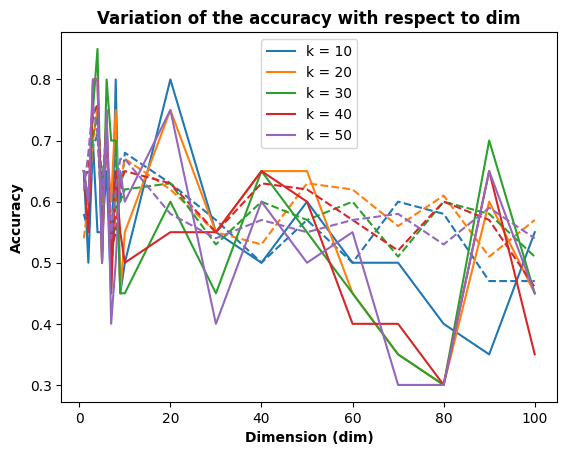

In [10]:
Accuracy = []
AccuracyCV = []
overlap = sigma
size = 50
for dim in dims:
    accuracy, accuracyCV = compute_scores(size,dim,overlap,k_range)
    Accuracy.append(accuracy)
    AccuracyCV.append(accuracyCV)
# Plotting
plt.figure()
for k_idx, k in enumerate(k_range):
    plt.plot(dims, [Accuracy[i][k_idx] for i in range(len(dims))], '-', c='C'+str(k_idx), label='k = '+str(k))
    plt.plot(dims, [AccuracyCV[i][k_idx] for i in range(len(dims))], '--', c='C'+str(k_idx))
plt.legend()
plt.xlabel("Dimension (dim)",fontweight="bold")
plt.ylabel("Accuracy",fontweight="bold")
plt.title("Variation of the accuracy with respect to dim",fontweight="bold")

In this evaluation, the measured accuracies are noisier than the previous mesurements. The CV have smaller variance though. Apperently, there is no combined effect between the parameter $k$ and the dimensions. We can only notice a trend of a decreasing accuracy with when the dimensions are increased. 

#### Conclusions

Considering the results shown above, we conduct the following:
* The accurace depends mainly on the overlap between the two gaussians. For an overlap $\delta > 8 \times \sigma$, the accuracy becomes perfect,
* The choice of $k$ should be in function of the sample size to get the best accuracy,
* The accuracy decreases when increasing the dimensions.

#### Questions:

* **Main difference between the KNN and a radius KNN classifier:**

The nearest neighbor methods consist in finding a known number of training samples, which has close distance to the new point and then determine the label accordingly [1](https://scikit-learn.org/stable/modules/neighbors.html). The difference between the KNN and the radius KNN classifier consist in the method used to determine the number of samples, such as:
1. For the ``k-Nearest-Neighbor`` method: The number of samples is a constant which is defined by the user,
2. For the ``Radius KNN classifier`` method: The number of samples can vary, and this is according to the points local density.

* **Case where one is better than the other:**
The ``k-Nearest-Neighbor`` performs well in solving classification and regression problems [1](https://scikit-learn.org/stable/modules/neighbors.html). This is made possible thanks to the constant number of samples in this algorithm, making it performant in classification problems (decision boundary are not regular).

## Exercise 8:   <a id='ex8'></a>

There are different methods to generate a similarity matrix given the distances between each point and the remaining ones. Here's some ways:

#### k-Nearest-Neighbor filter

This filter was already used in Exercice 6. It connects a point only to its $k$ nearest neighbors. However, this method do not lead to a symmetric matrix. For this reason, one may consider a point $i$ and $j$ connected if one of them is among the $k$ nearest neighbors from the other, or both of them should be among the $k$ nearest neighbor of each other.

In [2]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [3]:
def kNN_filter(dist_matrix,k):
    """
    k-Nearest-Neighbor filter applied on distance matrix

    Parameters
    ----------
    dist_matrix : Array of shape (N,N) with N number of points
        Distance matrix between each point with others.
    k : int
        Number nearest neighbors to search around each point.

    Returns
    -------
    filter_matrix : Array of the same shape as dist_matrix
        Each element in position (i,j) is equal to 1 if point j is among the k 
        nearest neighbor of pointj OR the inverse, and 0 otherwise.

    """
    
    N = len(dist_matrix)
    kNN_matrix = np.zeros((N,N)) # temporary matrix to store the kNN of each point
    filter_matrix = np.diag([1 for i in range(N)]) # the returned matrix, of course the diagonal elements equal to 1
    # search for k nearest neighbor by sorting the distance with all other points
    for i in range(N):
        sorted_neighbors = sorted(range(N), key = lambda l : dist_matrix[i,l])
        for j in range(k+1): # we add 1 to acount for the point it self (distance 0)
            kNN_matrix[i,sorted_neighbors[j]] = 1
    # fill the returned matrix in symmetric way
    for i in range(N):
        for j in range(i):
            if (kNN_matrix[i,j] == 1) or (kNN_matrix[j,i] == 1):
                filter_matrix[i,j], filter_matrix[j,i] = 1, 1  
    return filter_matrix

#### Radial Basis Function (RBF) kernel

The **Radial Basis Function (RBF) kernel** (also denoted **RBF kernel**) is, as the names indicates, a kernel which is commonly used in machine learning, in particular SVM classification [1](https://en.wikipedia.org/wiki/Radial_basis_function_kernel).

The application of RBF on two samples $x$ and $x'$ $\in \mathbb{R^k}$ is done according to the following equation:

$\boxed{K(x,x') = exp(-\frac{||x-x'||^2}{2 \sigma ^2})} \; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \; \; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \;  \;\;\;\; \; \;\; \; \;\; \;\; \;\; \; \;\; \; \;\; \;\;\; \;\; \;\; \; \;\; \; \;\; \; \;\; \; \; \mathbf{\text{(Eq(7.1))}}$

where $\sigma$ is a free parameter.

In [4]:
def RBF_filter(dist_matrix,sigma=1):
    """
    Radial basis function kernel. See [1]: 
    https://en.wikipedia.org/wiki/Radial_basis_function_kernel

    Parameters
    ----------
    dist_matrix : Array of shape (N,N) with N number of points
        Distance matrix between each point with others points.
    sigma : float, optional
        Free parameter (see formula). The default is 1.

    Returns
    -------
    filter_matrix : Array of the same shape as dist_matrix
        Matrix containing the RBF kernel for each with other points

    """

    N = len(dist_matrix)
    # Initiate the filter_matrix, all the elements on the diagonal equal to 1
    filter_matrix = np.diag([1.0 for i in range(N)])
    for i in range(N):
        for j in range(i):
            rbf = np.exp(-0.5*dist_matrix[i,j]*dist_matrix[i,j]/(sigma*sigma))
            filter_matrix[i,j], filter_matrix[j,i] = rbf, rbf
    return filter_matrix

#### Threshold

This filter creates un unweighted graph where only points with euclidean distance smaller that the threshold will be considered as connected. In some cases, the threshold may remove all the neighbors of a point, giving an isolated point. In order to avoid this situation, an isolated point will be connected to its nearest neighbor. The following implementaion can handel this situation.

In [5]:
def Threshold_filter(dist_matrix,threshold):
    """
    This filter creates un unweighted graph where only points with euclidean distance smaller that the 
    threshold will be considered as connected.
    The following inmplementation handels the case of **isolated points in the graph** :)
    
    Parameters
    ----------
    dist_matrix : Array of shape (N,N) with N number of points
        Distance matrix between each point with others points.
    threshold : float
        Points with distance bigger than threshold will be considered as unconnected.

    Returns
    -------
    filter_matrix : Array of the same shape as dist_matrix
        Matrix containing the RBF kernel for each with other points.

    """
    N = len(dist_matrix)
    filter_matrix = np.ones((N,N))
    
    # Apply the threshold 
    for i in range(N):
        for j in range(i):
            if dist_matrix[i,j] > threshold:
                filter_matrix[i,j], filter_matrix[j,i] = 0.0, 0.0
    
    # Check that there is no isolated points. If it is the case, it will be connected to its closest neighbor
    for i in range(N):
        alone = True
        min_dist = np.inf
        for j in range(N):
            if (i != j) and (filter_matrix[i,j] > 0.0):
                alone = False
                break
            elif (i != j) and (dist_matrix[i,j] < min_dist):
                min_dist = dist_matrix[i,j]
                min_idx = j
        if alone:
            filter_matrix[i,min_idx] = 1.0
            filter_matrix[min_idx,i] = 1.0
    return filter_matrix


### Similarity matrix visualization

Let us visualize some similarity matrices. We will start by generating dataset (Noisy Moons) and compute the euclidean distance between all the points.

In [6]:
# From exercise (6)
def compute_dist(pt1,pt2):
    """
    Compute the square euclidean distance between pt1 and pt2.
    Implemented for a generic dimension

    Parameters
    ----------
    pt1 : Array like
        The coordinate of the fisrt point
    pt2 : Array like
        The coordiantes of the second point

    Returns
    -------
    dist: float
        Squatred  Euclidian distance between pt1 and pt2

    """    
    return sum([(pt1[i]-pt2[i])**2 for i in range(len(pt1))])

def compute_dist_matrix(points):
    """
    Return the distance (squared euclidean distance) between each point with and all other point

    Parameters
    ----------
    points : Array_like of size n
        points cloud

    Returns
    -------
    dist_matrix : array like of shape (n,n)
        each element in position (i,j) represents the squared distance between point i and point j

    """    
    N = len(points)
    dist_matrix = np.zeros((N,N))
    for i in range(N):
        for j in range(i):
            dist = compute_dist(points[i], points[j])
            dist_matrix[i,j], dist_matrix[j,i] = dist, dist
    return dist_matrix

In [7]:
n_samples = 100
points, labels = datasets.make_moons(n_samples=n_samples, noise=.05)
dist_matrix = compute_dist_matrix(points)

We can first visualize the distance matrix. Then, the similarity matrix.

Text(0.5, 1.0, 'Distance matrix')

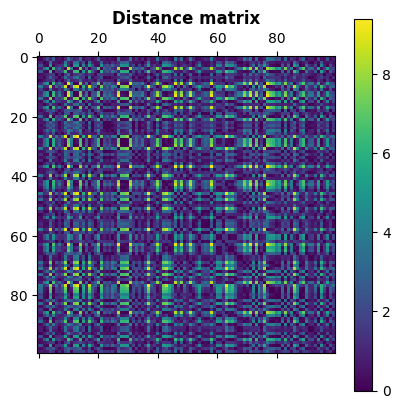

In [8]:
# Display the distance matrix
plt.matshow(dist_matrix)
plt.colorbar()
plt.title("Distance matrix",fontweight="bold")

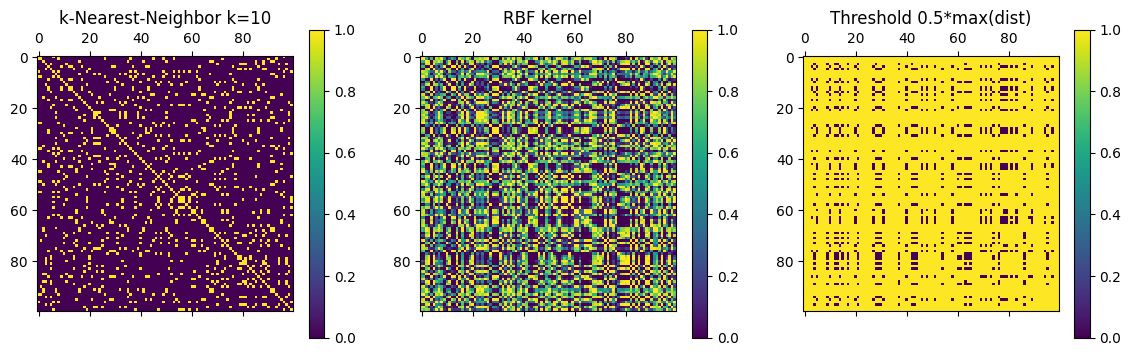

In [9]:
filter_matrices = {}
filter_matrices["k-Nearest-Neighbor k=10"] = kNN_filter(dist_matrix,10)
filter_matrices["RBF kernel"] = RBF_filter(dist_matrix)
filter_matrices["Threshold 0.5*max(dist)"] = Threshold_filter(dist_matrix,dist_matrix.max()/2.0)

fig, axs = plt.subplots(nrows = 1, ncols = len(filter_matrices), figsize=(14,4))
for idx, (key, filter_matrix) in enumerate(filter_matrices.items()):
    im = axs[idx].matshow(filter_matrix)
    plt.colorbar(im, ax=axs[idx])
    axs[idx].set_title(key)

#### References:
[1] https://en.wikipedia.org/wiki/Radial_basis_function_kernel

## Exercice 9:   <a id='ex9'></a>

This exercise aims at a comparative between both the **Ridge Regression** and **Lasso** algorithms. First, the best penalty value $\alpha$ is determined using cross-validation for both algorithms. They are both evaluated using metrics, such as the *mean-squared error* and the *R2-score*. Then, comparison graphs are generated in order to compare the perform of both algorithms and conduct relevant conclusions. For this test case, we will be using the **Diabetes dataset** from Lab 2.

In [41]:
#Import required libraries
import math
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV as gscv #GridSearchCV
from sklearn.model_selection import cross_val_score #CV
from sklearn.linear_model import Ridge as rg
from sklearn.linear_model import Lasso as ls
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import warnings as w

#### Diabetes dataset from Lab2

In [42]:
# Load the diabetes data
diabetes_ds = load_diabetes()

# print("====================")
# print("Diabetes dataframe ")
# print("====================")
# diabetes_ds

# Convert the diabetes data to dataframe
diabetes_df = pd.DataFrame(diabetes_ds.data)

#Features (variables)
X = diabetes_df.iloc[:,:-1]
#Target
y = diabetes_df.iloc[:,-1]

print("==============================")
print("Vars/traget, train/test shapes ")
print("==============================")
print("Features X shape: ", X.shape, "; Target y shape: ", y.shape)

#Splitting the dataset into trainset/testset (test data represent 20% of the total dataset)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

print("(X): ", "X_train shape = ", X_train.shape, "; X_test shape = ",X_test.shape)
print("(y): ", "y_train shape = ", y_train.shape, "y_test shape = ",y_test.shape)

Vars/traget, train/test shapes 
Features X shape:  (442, 9) ; Target y shape:  (442,)
(X):  X_train shape =  (353, 9) ; X_test shape =  (89, 9)
(y):  y_train shape =  (353,) y_test shape =  (89,)


In [12]:
# print("==============================")
# print("Dataset min and max values ")
# print("==============================")
# Convert pd series to lists
# list_xmin = X.min().tolist()
# list_xmax = X.max().tolist()
# list_ymin = y.min().tolist()
# list_ymax = y.max().tolist()
#
# print("(X):", "X_min=\n", list_xmin, "\n X_max=\n",list_xmax)
# print("(y):", "y_min=\n", list_ymin, "\n y_max=\n", list_ymax)

### Part 1 : Searching for a good $\alpha$ regularization penalty using Cross-Validation (Comparison between Ridge Regression and Lasso)

#### Ridge Regression Model

The purpose of the **Ridge regression** algorithm is to find a line that fits the training set according to a certain bias (introduced by a certain penalty $\alpha$), resulting in reducing the data variance. It minimizes the problem described by the following equation [1](http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/2020-02-07_sklapi.html):

$\boxed{min_{slope}\; E(\alpha,slope) = \sum_{i=1}^{n} (y_i - X_i \times slope)^2 + \alpha ||slope||^2 } \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\mathbf{(\text{Eq.} \; (9.1))}$

According to the equation (9.1), the Ridge regression algorithm minimizes the sum of the squared residual plus a ridge penalty equal to $ \alpha ||slope||^2$. This penalty affects how the line is fit to the data. In fact, if we increase the penalty value, then the slope of the fitted line becomes smaller, and thus the predictions of the target $y$ become less sensitive to changes in the variables $X$. Therefore, the penalty value should be chosen wisely. In order to do so, we use a *10-folded cross-validation* in order to determine the penalty value $\alpha$ (a hyperparameter) giving a low variance.

First, we define the values of the candidates $\alpha$ using a *linspace* of $100$ points in the range from $10^{-10}$ to $1$. The ridge regression with the selected $\alpha$ is then trained on the trainset and evaluated using metrics such as the mean-squared error. The predictions on the testset are also made and the error between the real target and the predicted values is also evaluated.

In [13]:
# Ridge regression object creation
ridge_cv = rg()

#Perform Grid search to find the best penalty value alpha (greater than zero)
rg_best_penalty = gscv(estimator=ridge_cv, param_grid = {'alpha': np.logspace(-10,-2,100)}, 
                              scoring='neg_mean_squared_error', cv=10)

In [14]:
# Training using Ridge regression
# rg_best_penalty.fit(X,y)
rg_best_penalty.fit(X_train,y_train)

# Prediction using Ridge regression
prediction_rg = rg_best_penalty.predict(X_test)

print("==============================")
print("About Ridge Regression ")
print("==============================")
# Best penalty value alpha
print("Best penalty value among given ones: ", rg_best_penalty.best_params_)
# Verification using the mean-square error
print("Mean-CV score of the best_estimator: ", abs(rg_best_penalty.best_score_))
print("Mean-squared error (test-prediction): %.2f" % mean_squared_error(y_test, prediction_rg))
# Variance score of the prediction
print('Variance score: %.2f' % r2_score(y_test, prediction_rg))
print("R2_score of Ridge Regression: ", r2_score(y_test, prediction_rg))

About Ridge Regression 
Best penalty value among given ones:  {'alpha': 0.01}
Mean-CV score of the best_estimator:  0.0016354528405387943
Mean-squared error (test-prediction): 0.00
Variance score: 0.36
R2_score of Ridge Regression:  0.36354510094794557


These results show that the best penalty $\alpha$ of the Ridge Regression algorithm using cross-validation is equal to $0.01$. 

In what follows, the ridge regression model using the found value $\alpha$ is fit on the trainset in order to extract the model coefficients for all features X.

In [15]:
# Ridge regression coefficients
# Ret-training the model using the found alpha value
ridge_cv_alpha = rg(alpha=0.01)
ridge_cv_alpha.fit(X_train,y_train)

# Ridge regression coeff are stored in a dict
coeff_rg = {}
for coeff, feature_idx in zip(ridge_cv_alpha.coef_,range(10)):
    coeff_rg[(feature_idx)] = coeff
print("=============================")
print("Ridge Regression Coeffs ")
print("=============================")
coeff_rg

Ridge Regression Coeffs 


{0: 0.09245022598298061,
 1: 0.07238233168838264,
 2: 0.1248731899364324,
 3: 0.17569325340320607,
 4: 0.03946338835921483,
 5: -0.00812866581509545,
 6: 0.04580420952880007,
 7: 0.1390964411939087,
 8: 0.20961545620846686}

#### Lasso Model

The purpose of the **Lasso** algorithm is to find a line that fits the training set according to a certain bias (**smaller than the one of Ridge regression** and introduced by a certain penalty $\alpha$). It minimizes the problem described by the following equation [1](http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/2020-02-07_sklapi.html):

$\boxed{min_{slope}\; E(\alpha,slope) = \sum_{i=1}^{n} (y_i - X_i \times slope)^2 + \alpha ||slope|| } \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \;\;\mathbf{(\text{Eq.} \; (9.2))}$

According to the equation (9.2), the Lasso algorithm minimizes the sum of the squared residual plus a ridge penalty equal to $ \alpha ||slope||^2$. Just like Ridge regression, $\alpha$ is a value ranging from 0 to infinity and could be determined using cross validation. 

In what follows, we use a *10-folded cross-validation* in order to determine the penalty value $\alpha$ (a hyperparameter) giving a low variance using the Lasso algorithm.

In [16]:
# Lasso object creation
ls_reg = ls(normalize=True, tol=1e-2)

#Perform Grid search to find the best penalty value alpha (greater than zero)
ls_best_penalty = gscv(estimator=ls_reg, param_grid = {'alpha': np.logspace(-10,-2,100)}, 
                              scoring='neg_mean_squared_error',cv=5)

In [17]:
# Model training using Lasso
ls_best_penalty.fit(X_train, y_train)

w.filterwarnings('ignore')

# Prediction using Lasso
prediction_ls = ls_best_penalty.predict(X_test)

print("==============================")
print("About Lasso ")
print("==============================")
# Best penalty value alpha
print("Best penalty value among given ones: ", ls_best_penalty.best_params_)
# Verification using the mean-square error
print("Mean-CV score of the best_estimator: ", abs(ls_best_penalty.best_score_))
print("Mean-squared error (test-prediction): %.2f" % mean_squared_error(y_test, prediction_ls))
# Variance score of the prediction
print('Variance score: %.2f' % r2_score(y_test, prediction_ls))
print("R2_score of Lasso: ", r2_score(y_test, prediction_ls))

About Lasso 
Best penalty value among given ones:  {'alpha': 1.788649529057435e-05}
Mean-CV score of the best_estimator:  0.001662978557718035
Mean-squared error (test-prediction): 0.00
Variance score: 0.36
R2_score of Lasso:  0.36260423907335504


These results show that the best penalty $\alpha$ of the Lasso algorithm using cross-validation is equal to $1.788649529057435e-05$. 

### Part 2 : Plottings (inspired from Lab2)

In [46]:
# Interval of the penalty values alpha
val_penalty = np.logspace(-10, -2, 100)
# Coefficients
coefs_rg = []
coefs_ls = []
# R2 score
r2_rg = []
r2_ls = []
# Mean-square errors
MSE_rg = []
MSE_ls = []


### Ridge Regression ###
for i in val_penalty:
    
    # Ridge Regression training
    regressor_ridge = rg(alpha=i, fit_intercept=False)
    regressor_ridge.fit(X_train, y_train)
    
    # Prediction using Ridge Regression of testset
    prediction_rg_alpha = regressor_ridge.predict(X_test)
    
    # Ridge Regression Coefficients
    coefs_rg.append(regressor_ridge.coef_)
    
    # R2_score of Ridge Regression
    r2_rg.append(r2_score(y_test, prediction_rg_alpha))
    
    # Mean-square errors using Ridge Regression
    MSE_rg.append(mean_squared_error(y_test, prediction_rg_alpha))
# coefs_rg

### Lasso ###
for j in val_penalty:
    
    # Lasso training
    regressor_ls = ls(alpha=j, normalize=True, tol=1e-2, fit_intercept=False)
    regressor_ls.fit(X_train, y_train)
    
    # Prediction using Lasso of testset
    prediction_ls_alpha = regressor_ls.predict(X_test)
    
    # Lasso Coefficients
    coefs_ls.append(regressor_ls.coef_)
    
    # R2_score of Lasso
    r2_ls.append(r2_score(y_test, prediction_ls_alpha))
    
    # Mean-square errors using Lasso
    MSE_ls.append(mean_squared_error(y_test, prediction_ls_alpha))
    
# coefs_ls
w.filterwarnings('ignore')

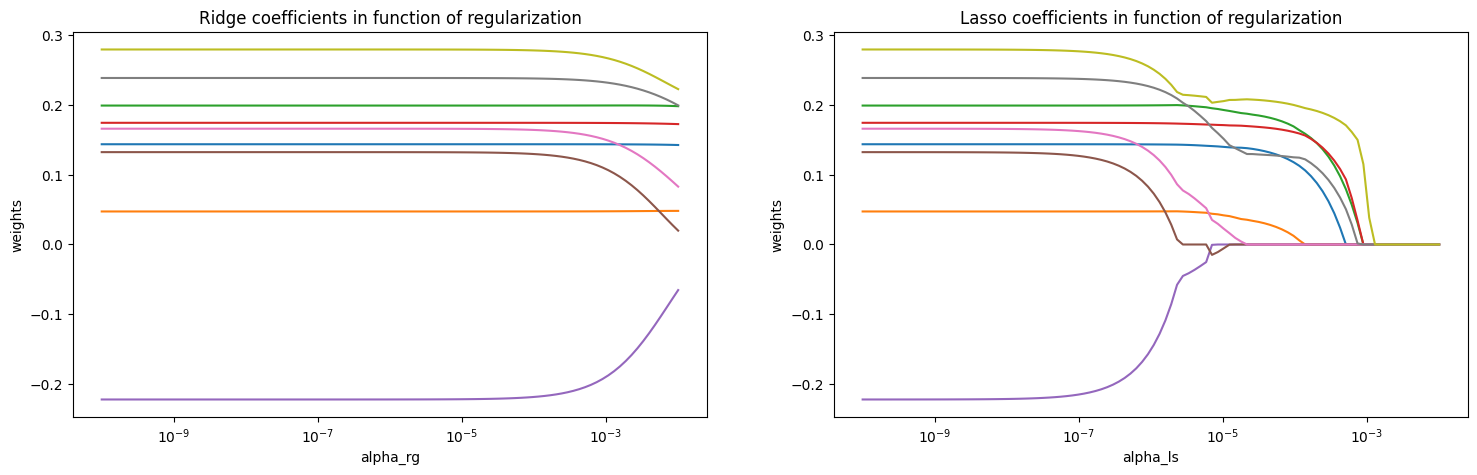

In [47]:
# Plotting the weights as a function of coefficients for both Ridge Regression and Lasso
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

# Ridge Regression
ax1.plot(val_penalty, coefs_rg)
ax1.set_xscale('log')
ax1.set_title('Ridge coefficients in function of regularization')
ax1.set(xlabel='alpha_rg', ylabel='weights')

# Lasso
ax2.plot(val_penalty, coefs_ls)
ax2.set_xscale('log')
ax2.set_title('Lasso coefficients in function of regularization')
ax2.set(xlabel='alpha_ls', ylabel='weights')

plt.axis('tight')
plt.show()

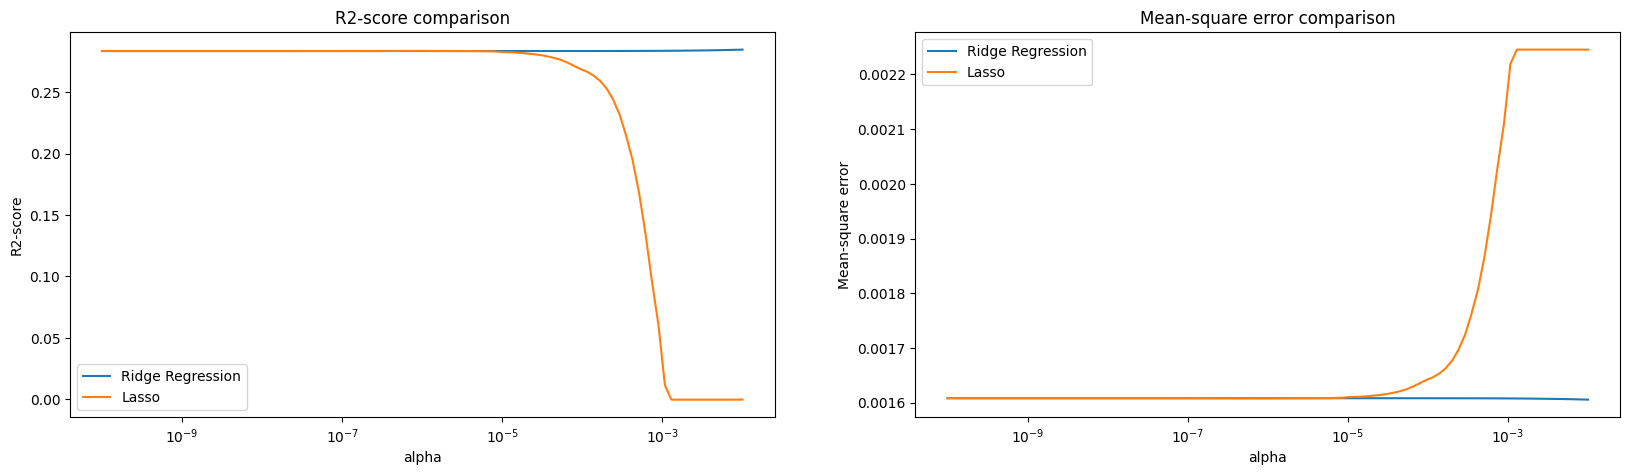

In [350]:
# Plotting the weights as a function of coefficients for both Ridge Regression and Lasso
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

# R2-score comparison
fig1 = ax1.plot(val_penalty, r2_rg, label='Ridge')
fig2 = ax1.plot(val_penalty, r2_ls, label='Lasso')
ax1.set_xscale('log')
ax1.set_title('R2-score comparison')
ax1.set(xlabel='alpha', ylabel='R2-score')
ax1.legend(['Ridge Regression', 'Lasso'])

# Mean-square error comparison
fig3 = ax2.plot(val_penalty, MSE_rg, label='Ridge')
fig4 = ax2.plot(val_penalty, MSE_ls, label='Lasso')
ax2.set_xscale('log')
ax2.set_title('Mean-square error comparison')
ax2.set(xlabel='alpha', ylabel='Mean-square error')
ax2.legend(['Ridge Regression', 'Lasso'])

Considering the graphs above, the following conclusions could be conducted:
* The R2-score of the Ridge Regression is better than Lasso algorithm as a function of $\alpha$,
* The mean-square error of the Ridge Regression is lower than Lasso as a function of $\alpha$.

#### Comparison of the Ridge Regression and Lasso algorithms: Conclusions

Although both the Ridge Regression and Lasso algorithms have almost the same aim of lowering the data variance by introducing a certain bias resulting from the addition of a penalty $\alpha$, once can see from equations (9.1) and (9.2) that they are not dealing with the same minimization problem.

Comparing both scoring results of Ridge Regression and Lasso, one can conclude that the Ridge regression performs slightly better than Lasso. This is explained by the following statements:

* ``Lasso :`` Minimizes ($MSE + \alpha \; slope$).
* ``Ridge Regression :`` Minimizes ($MSE + \alpha \; slope^2$).

where $MSE$ is the mean-square error. Therefore, one can conclude that somehow Lasso algorithm ignores some features, unlike Ridge Regression algorithm.

#### References:

[1] http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/2020-02-07_sklapi.html